In this notebook, we investigate several patterns in function of the predicted insights and their position. Are models more likely to produce correct insights first? Are there any obvious patterns in terms of the ranking of the answers and their propensity to hallucinate? What about the attribution of their answers? Can we determine which documents models are more likely to extract information from?


**Table of contents**:
---

1. Relationship between position and correctness of the insight;
2. Relationship between position and insight location (in the document);

---


In [3]:
import os, json, glob

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from collections import defaultdict
from matplotlib.ticker import MultipleLocator, PercentFormatter

# Put at top of plotting script (requires tex be installed though)
matplotlib.rc('font', family='serif')

FULL_WIDTH = 6.75133
COL_WIDTH  = 3.25063


def adjust(fig, left=0.0, right=1.0, bottom=0.0, top=1.0, wspace=0.0, hspace=0.0):
    fig.subplots_adjust(
        left   = left,  # the left side of the subplots of the figure
        right  = right,  # the right side of the subplots of the figure
        bottom = bottom,  # the bottom of the subplots of the figure
        top    = top,  # the top of the subplots of the figure
        wspace = wspace,  # the amount of width reserved for blank space between subplots
        hspace = hspace,  # the amount of height reserved for white space between subplots
    )


def remove_axes(ax):
    ax.spines[['right', 'top']].set_visible(False)


def read_json(fp):
    with open(fp) as f:
        return json.load(f)


def save_fig(fig, name, dpi=200, base_dir="../paper-oct/images", **kwargs):
    import os
    path = f"{base_dir}/{name}"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    print(f"Image saved in {path}")
    fig.savefig(path, dpi=dpi, bbox_inches='tight', **kwargs)


# User defined
from readers import read_and_merge_paths

### Variables

In [4]:
COMBINATIONS = (2, 3, 4, 5, 10)

MODELS = (
    "accounts/fireworks/models/llama-v3p1-70b-instruct",
    "gpt-4o-2024-05-13",
    "gpt-3.5-turbo-0125",
    "accounts/fireworks/models/qwen2-72b-instruct",
    "gemini-1.5-flash",
)

PROMPT_TYPES = (
    "subtopic",
    "subtopic_trustworthy",
)

## How does the relationship change per model?


In [5]:
def collect_correctness_by_position(
    labels, 
    ref_is_queried_subtopic: bool=True,
    ref_is_shared: bool=False,
    max_rank=None,
) -> pd.DataFrame:
    """Compute the recall per response id."""
    def get_num_ref_labels(ls):
        ref_labels = [l for l in ls if l["ref_uuid"] is not None]
        if ref_is_queried_subtopic:
            ref_labels = [l for l in ref_labels if l["ref_is_queried_subtopic"]]
        if ref_is_shared:
            ref_labels = [l for l in ref_labels if l["ref_is_shared"]]
        return len(ref_labels)
        
    labels_by_idx = defaultdict(list)
    for label in labels:
        labels_by_idx[label["response_idx"]].append(label)
    
    results = defaultdict(list)
    for resp_uuid, labels in labels_by_idx.items():
        # Determine the number of expected relevant insights
        pred_labels = [l for l in labels if l["pred_uuid"] is not None]
        assert labels[0]["num_preds"] == len(pred_labels)

        num_refs = get_num_ref_labels(labels)
        num_preds = len(pred_labels)
        if max_rank is not None:
            if isinstance(max_rank, int):
                num_preds = max_rank
            elif max_rank == "num_refs":
                num_preds = num_refs
            else:
                raise ValueError("Unclear value for max_rank")

        preds_to_correctness = {l["pred_rank"]: l["coverage"] for l in pred_labels}
        
        for i in range(num_preds):
            results["response_id"].extend([resp_uuid, resp_uuid])
            results["label_type"].extend(["fc", "fc+pc"])

            pred = preds_to_correctness.get(i, None)
            results["rank"].extend([i] * 2)
            results["correct"].extend([pred == "FULL_COVERAGE", pred in ("FULL_COVERAGE", "PARTIAL_COVERAGE")])

            results["compute_recall_kwargs"].extend([{
                "max_rank": max_rank,
                "ref_is_shared": ref_is_shared,
                "ref_is_queried_subtopic": ref_is_queried_subtopic,
            }] *2)
    return pd.DataFrame(results)

In [6]:
metric = "bidirectional"
domain = "conv"
base_dir = f"../outputs_{domain}/run_final_postprocessing-multi-request/gpt-4o-mini-2024-07-18/results_some_shared"

max_rank = None # "num_refs" # 2
all_recall_results = []
all_err_rate_results = []
for model in MODELS:
    for prompt in PROMPT_TYPES:
        for combination in COMBINATIONS:
            filepaths = sorted(glob.glob(f"{base_dir}/{prompt}/SummHay__combinations-{combination}/{model}/{metric}__*.json"))
            for filepath in filepaths: 
                data = read_json(filepath)
                recall = collect_correctness_by_position(data["labels"],
                                        ref_is_queried_subtopic=True,
                                        ref_is_shared=(prompt == "subtopic_trustworthy"),
                                        max_rank=max_rank)

                for df in (recall,):
                    df["summarizer_model"] = model.rpartition("/")[-1]
                    df["prompt"] = prompt
                    df["num_documents"] = combination
                    df["metric"] = metric
                    df["filepath"] = filepath.rpartition(metric + "__")[-1]

                all_recall_results.append(recall)

all_recall_results = pd.concat(all_recall_results)
all_recall_results.head()

response_id label_type  rank  correct  \
0            0         fc     0    False   
1            0      fc+pc     0     True   
2            0         fc     1    False   
3            0      fc+pc     1    False   
4            0         fc     2    False   

                               compute_recall_kwargs         summarizer_model  \
0  {'max_rank': None, 'ref_is_shared': False, 're...  llama-v3p1-70b-instruct   
1  {'max_rank': None, 'ref_is_shared': False, 're...  llama-v3p1-70b-instruct   
2  {'max_rank': None, 'ref_is_shared': False, 're...  llama-v3p1-70b-instruct   
3  {'max_rank': None, 'ref_is_shared': False, 're...  llama-v3p1-70b-instruct   
4  {'max_rank': None, 'ref_is_shared': False, 're...  llama-v3p1-70b-instruct   

     prompt  num_documents         metric  \
0  subtopic              2  bidirectional   
1  subtopic              2  bidirectional   
2  subtopic              2  bidirectional   
3  subtopic              2  bidirectional   
4  subtopic              2  bidirectional   

                               filepath  
0  topic_conv1__300__examples0,100.json  
1  topic_conv1__300__examples0,100.json  
2  topic_conv1__300__examples0,100.json  
3  topic_conv1__300__examples0,100.json  
4  topic_conv1__300__examples0,100.json

In [7]:
all_recall_results[all_recall_results["rank"] == 0].groupby(["num_documents", "summarizer_model", "label_type", "prompt"]).count()

response_id  \
num_documents summarizer_model        label_type prompt                              
2             gemini-1.5-flash        fc         subtopic                      341   
                                                 subtopic_trustworthy          341   
                                      fc+pc      subtopic                      341   
                                                 subtopic_trustworthy          341   
              gpt-3.5-turbo-0125      fc         subtopic                      341   
...                                                                            ...   
10            llama-v3p1-70b-instruct fc+pc      subtopic_trustworthy          500   
              qwen2-72b-instruct      fc         subtopic                      500   
                                                 subtopic_trustworthy          500   
                                      fc+pc      subtopic                      500   
                                                 subtopic_trustworthy          500   

                                                                       rank  \
num_documents summarizer_model        label_type prompt                       
2             gemini-1.5-flash        fc         subtopic               341   
                                                 subtopic_trustworthy   341   
                                      fc+pc      subtopic               341   
                                                 subtopic_trustworthy   341   
              gpt-3.5-turbo-0125      fc         subtopic               341   
...                                                                     ...   
10            llama-v3p1-70b-instruct fc+pc      subtopic_trustworthy   500   
              qwen2-72b-instruct      fc         subtopic               500   
                                                 subtopic_trustworthy   500   
                                      fc+pc      subtopic               500   
                                                 subtopic_trustworthy   500   

                                                                       correct  \
num_documents summarizer_model        label_type prompt                          
2             gemini-1.5-flash        fc         subtopic                  341   
                                                 subtopic_trustworthy      341   
                                      fc+pc      subtopic                  341   
                                                 subtopic_trustworthy      341   
              gpt-3.5-turbo-0125      fc         subtopic                  341   
...                                                                        ...   
10            llama-v3p1-70b-instruct fc+pc      subtopic_trustworthy      500   
              qwen2-72b-instruct      fc         subtopic                  500   
                                                 subtopic_trustworthy      500   
                                      fc+pc      subtopic                  500   
                                                 subtopic_trustworthy      500   

                                                                       compute_recall_kwargs  \
num_documents summarizer_model        label_type prompt                                        
2             gemini-1.5-flash        fc         subtopic                                341   
                                                 subtopic_trustworthy                    341   
                                      fc+pc      subtopic                                341   
                                                 subtopic_trustworthy                    341   
              gpt-3.5-turbo-0125      fc         subtopic                                341   
...                                                                                      ...   
10            llama-v3p1-70b-instruct fc+pc      subtopic_trustworthy                    

Image saved in ../paper-oct/images/conv/bidirectional/lineplot/output-position-corr/subtopic__10.png


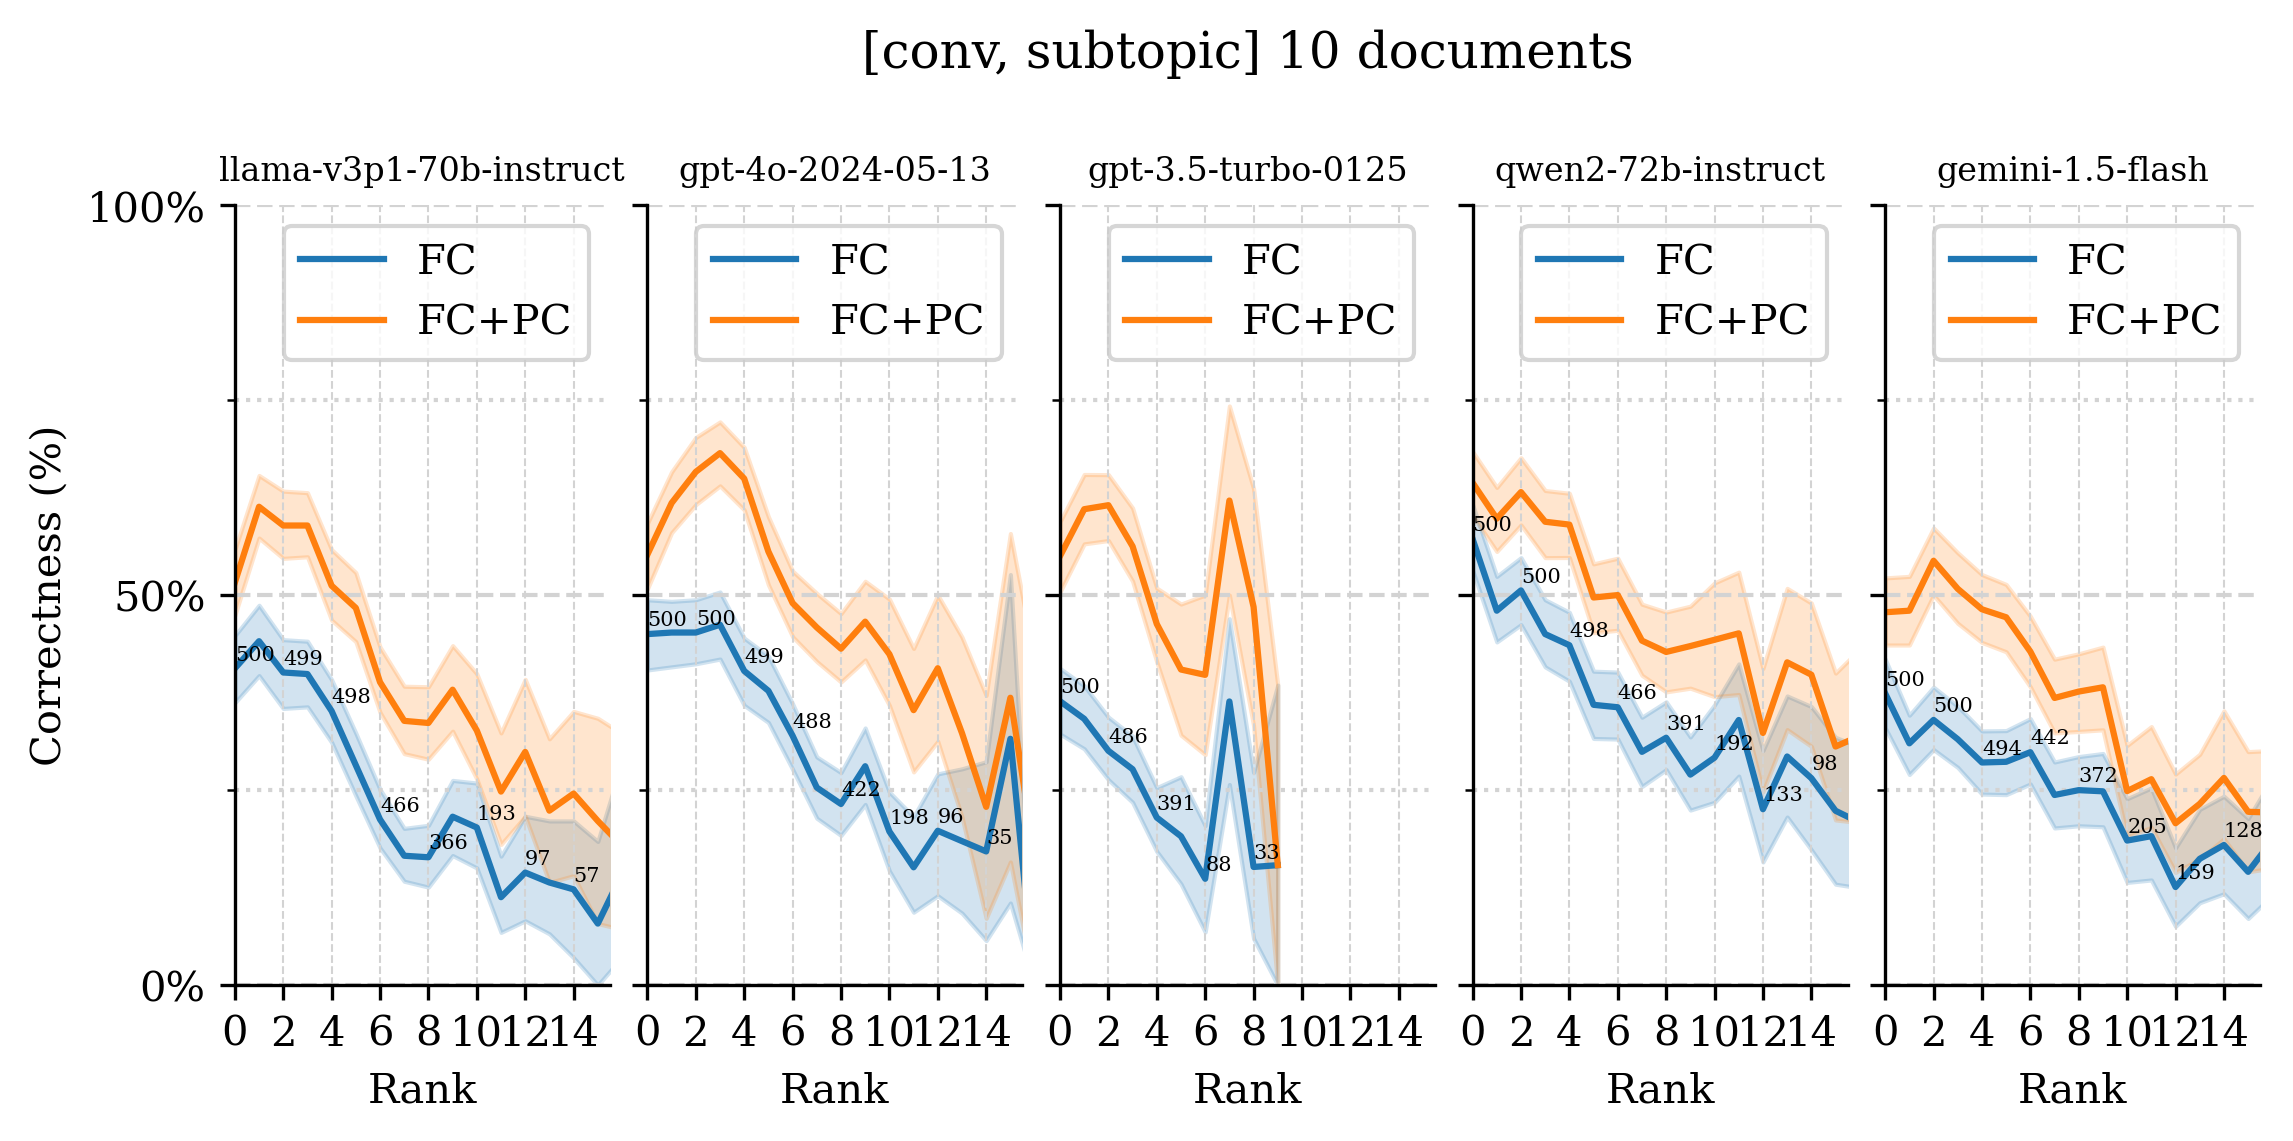

In [43]:
num_combinations = 10
prompt_type = "subtopic"

subset = all_recall_results[
    (all_recall_results["prompt"] == prompt_type)
    & (all_recall_results["num_documents"] == num_combinations)
    # & (all_recall_results["label_type"] == "fc+pc")
]

fig, axes = plt.subplots(1, len(MODELS), sharey=True, sharex=True, figsize=(FULL_WIDTH, COL_WIDTH), dpi=300)
fig.suptitle(f"[{domain}, {prompt_type}] {num_combinations} documents")


i = 0
for ax, model in zip(axes, MODELS):
    subset_model = subset[subset["summarizer_model"] == model.rpartition("/")[-1]].copy()

    subset_model_fc = subset_model[subset_model["label_type"] == "fc"]
    sns.lineplot(subset_model_fc, x="rank", y="correct", label="FC", ax=ax)

    subset_model_fcpc = subset_model[subset_model["label_type"] == "fc+pc"]
    sns.lineplot(subset_model_fcpc, x="rank", y="correct", label="FC+PC", ax=ax)

    colors = sns.color_palette("tab10", n_colors=2)
    for i, line in enumerate(ax.get_lines()):
        # Get data points
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        
        # Create a DataFrame for annotation
        annotation_df = subset_model_fcpc.groupby(["rank", "correct"]).size().reset_index(name='count')
        
        for i, (x, y) in enumerate(zip(x_data, y_data)):
            if i % 2 == 0:
                # Find count of examples
                count = annotation_df[(annotation_df["rank"] == x)]['count'].values

                
                # Annotate the point
                ax.annotate(f'{np.sum(count)}', xy=(x, y), xytext=(0, 2), textcoords='offset points', fontsize=8
                            #arrowprops=dict(facecolor='black', arrowstyle='->'),)
                )
        break

    
    ax.set_title(model.rpartition("/")[-1], fontsize=8)
    remove_axes(ax)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Correctness (%)")
    
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.50))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))


    ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
    ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
    ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 15.5)

adjust(fig, wspace=0.1, top=0.80)
save_fig(fig, f"{domain}/{metric}/lineplot/output-position-corr/{prompt_type}__{num_combinations}.png", dpi=300)

Image saved in ../paper-oct/images/conv/bidirectional/lineplot/output-position-corr/subtopic_trustworthy__5.png


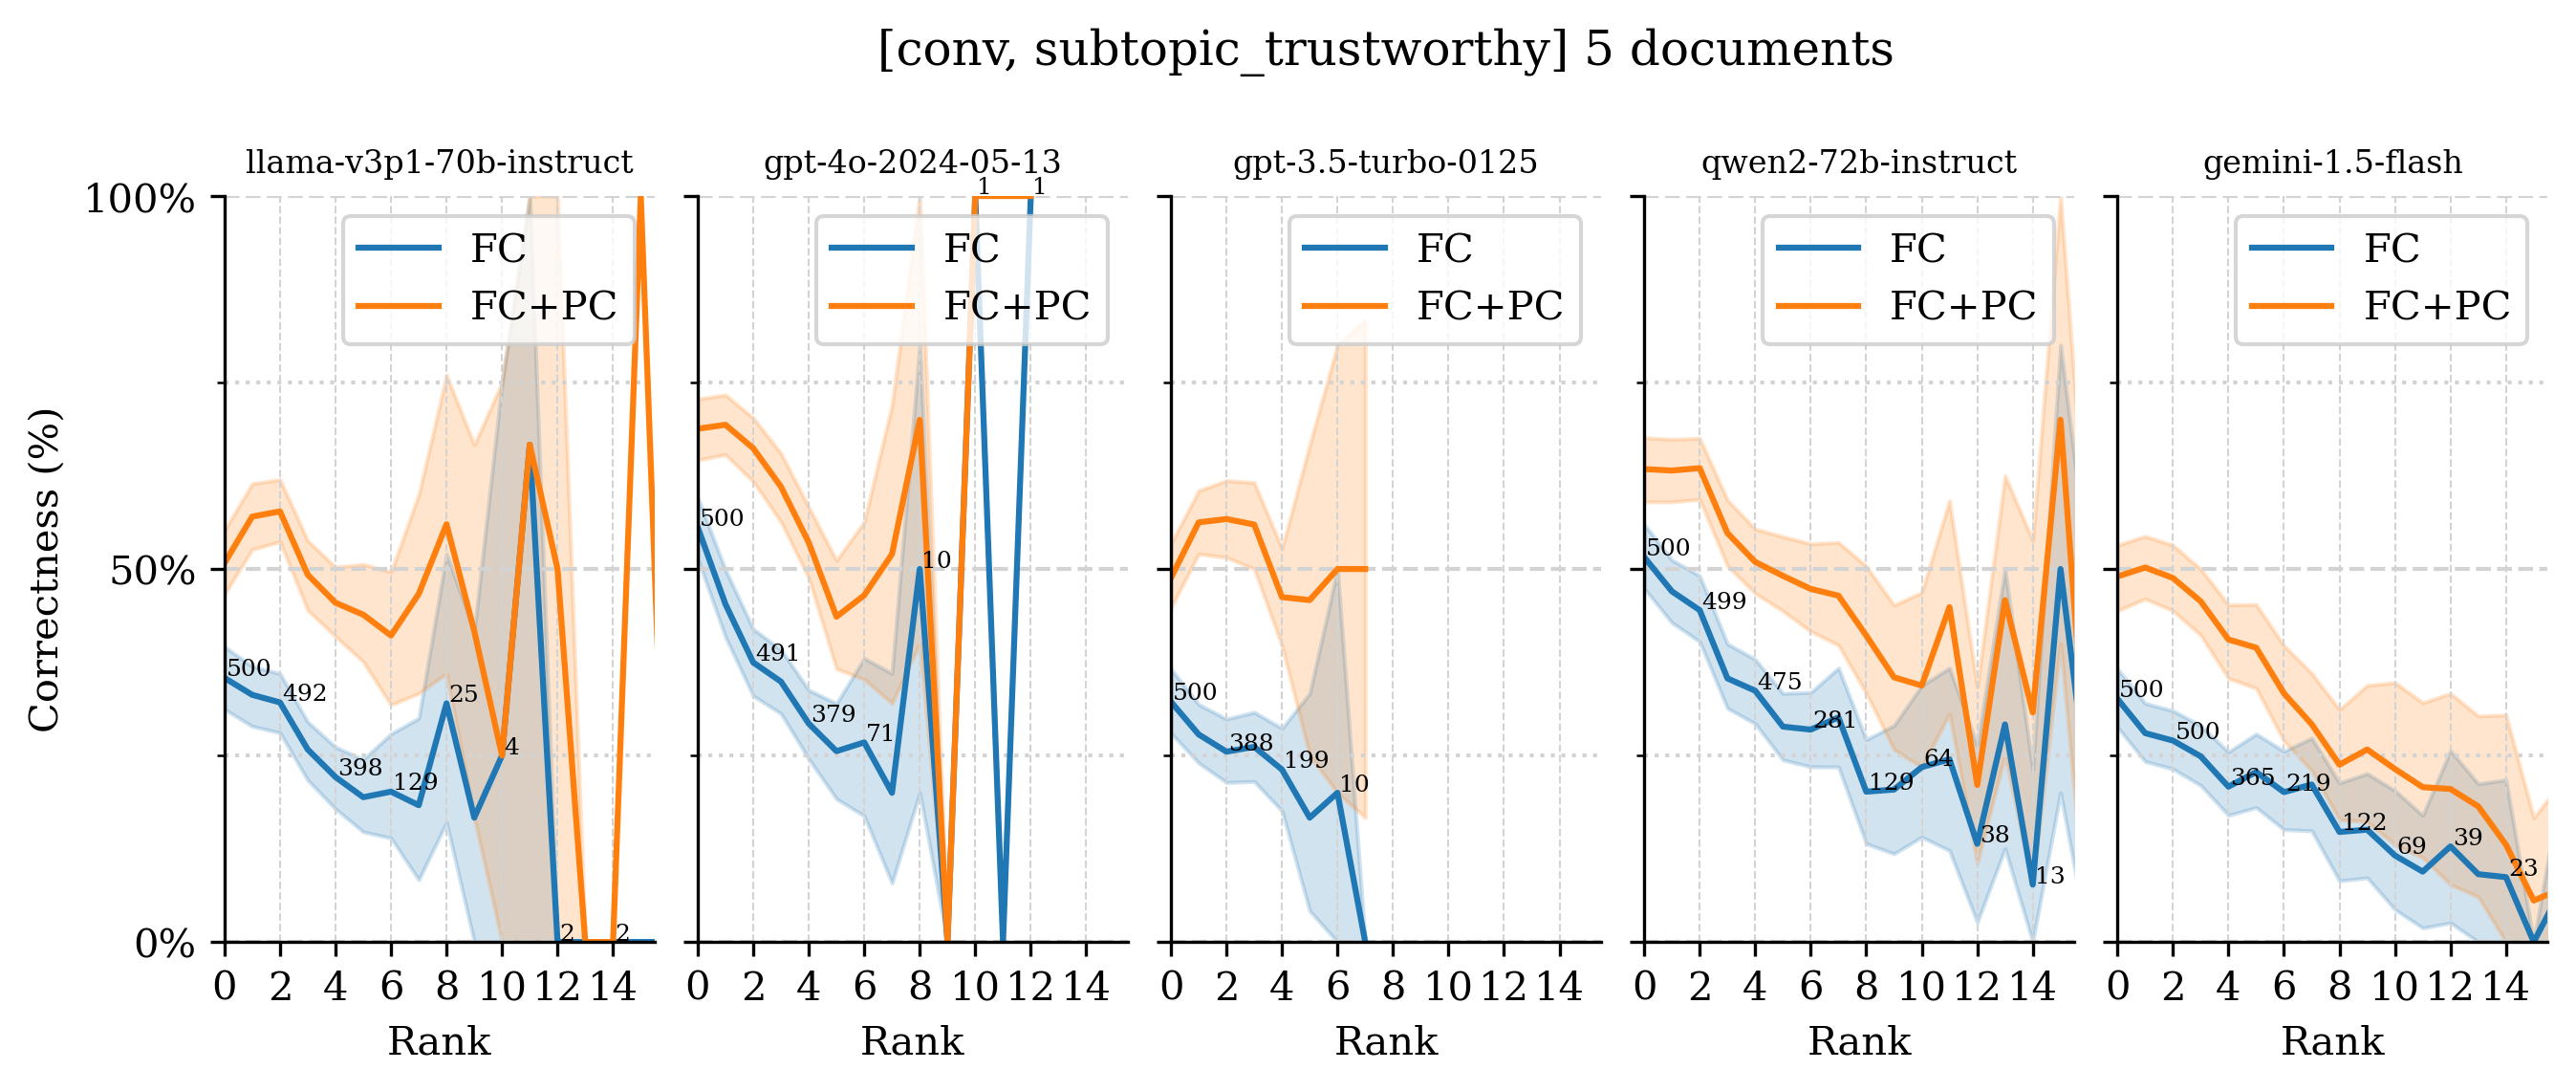

In [44]:
num_combinations = 5
prompt_type = "subtopic_trustworthy"

subset = all_recall_results[
    (all_recall_results["prompt"] == prompt_type)
    & (all_recall_results["num_documents"] == num_combinations)
    # & (all_recall_results["label_type"] == "fc+pc")
]

fig, axes = plt.subplots(1, len(MODELS), sharey=True, sharex=True, figsize=(FULL_WIDTH*1.2, COL_WIDTH), dpi=300)
fig.suptitle(f"[{domain}, {prompt_type}] {num_combinations} documents")


i = 0
for ax, model in zip(axes, MODELS):
    subset_model = subset[subset["summarizer_model"] == model.rpartition("/")[-1]].copy()

    subset_model_fc = subset_model[subset_model["label_type"] == "fc"]
    sns.lineplot(subset_model_fc, x="rank", y="correct", label="FC", ax=ax)

    subset_model_fcpc = subset_model[subset_model["label_type"] == "fc+pc"]
    sns.lineplot(subset_model_fcpc, x="rank", y="correct", label="FC+PC", ax=ax)

    colors = sns.color_palette("tab10", n_colors=2)
    for i, line in enumerate(ax.get_lines()):
        # Get data points
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        
        # Create a DataFrame for annotation
        annotation_df = subset_model_fcpc.groupby(["rank", "correct"]).size().reset_index(name='count')
        
        for i, (x, y) in enumerate(zip(x_data, y_data)):
            if i % 2 == 0:
                # Find count of examples
                count = annotation_df[(annotation_df["rank"] == x)]['count'].values
                
                # Annotate the point
                ax.annotate(f'{np.sum(count)}', xy=(x, y), xytext=(0.5, 0.5), textcoords='offset points', fontsize=6
                            #arrowprops=dict(facecolor='black', arrowstyle='->'),)
                )
        break

    
    ax.set_title(model.rpartition("/")[-1], fontsize=8)

    remove_axes(ax)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Correctness (%)")
    
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.50))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
    ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
    ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 15.5)

adjust(fig, wspace=0.1, top=0.80)
save_fig(fig, f"{domain}/{metric}/lineplot/output-position-corr/{prompt_type}__{num_combinations}.png", dpi=300)

Image saved in ../paper-oct/images/conv/bidirectional/lineplot/output-position-corr/subtopic_trustworthy__5.png


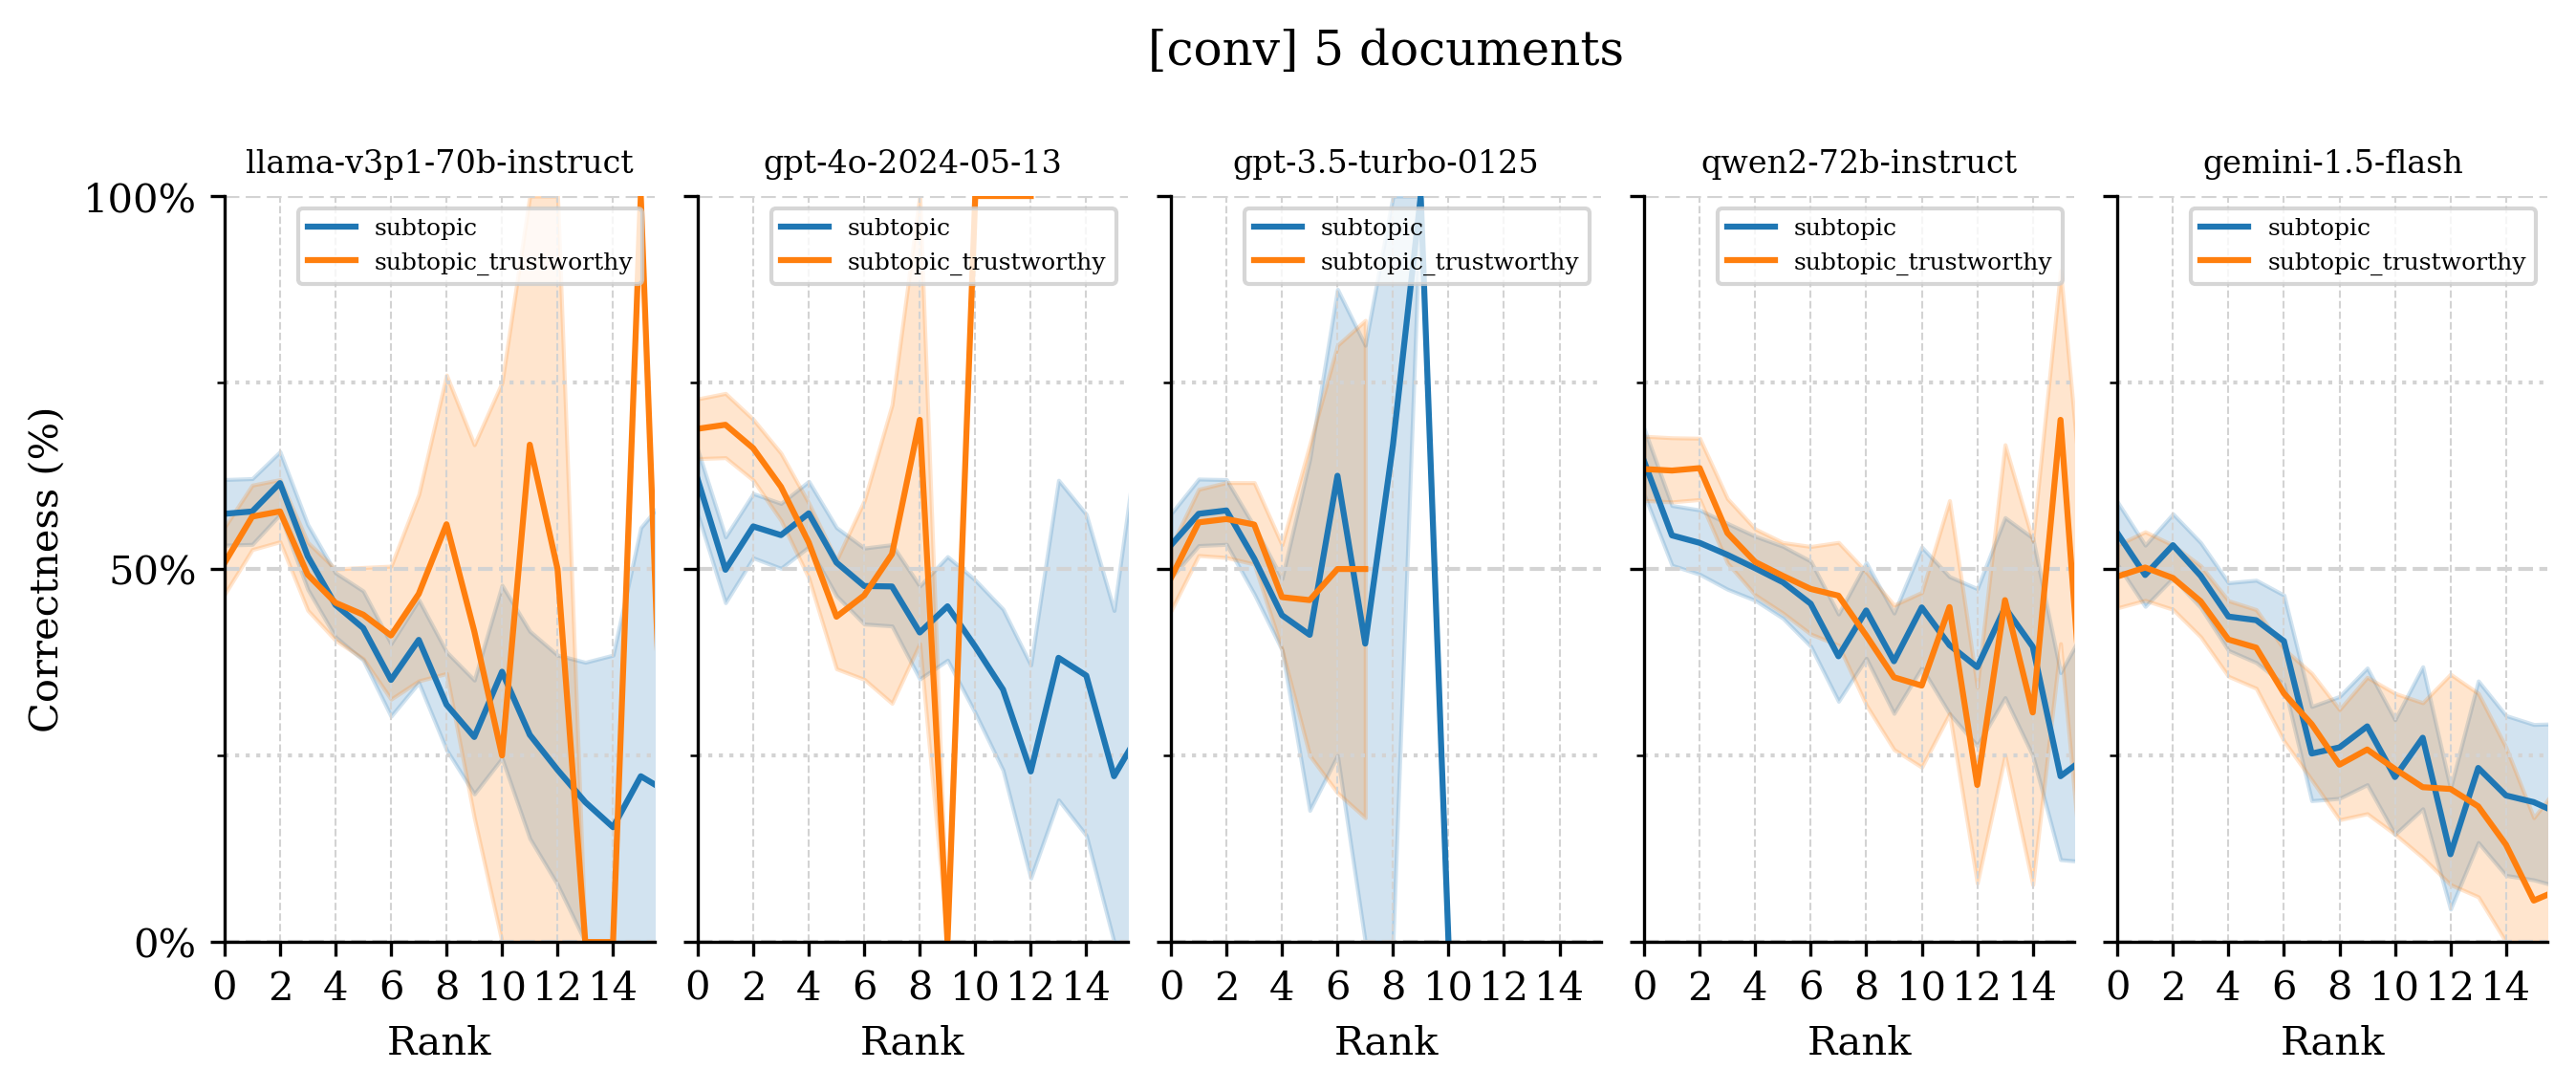

In [45]:
num_combinations = 5

subset = all_recall_results[
    (all_recall_results["num_documents"] == num_combinations)
    & (all_recall_results["label_type"] == "fc+pc")
]

fig, axes = plt.subplots(1, len(MODELS), sharey=True, sharex=True, figsize=(FULL_WIDTH*1.2, COL_WIDTH), dpi=300)
fig.suptitle(f"[{domain}] {num_combinations} documents")


i = 0
for ax, model in zip(axes, MODELS):
    subset_model = subset[subset["summarizer_model"] == model.rpartition("/")[-1]].copy()

    sns.lineplot(subset_model, x="rank", y="correct", hue="prompt", ax=ax) # change color
    ax.set_title(model.rpartition("/")[-1], fontsize=8)
    remove_axes(ax)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Correctness (%)")
    
    # Create a DataFrame for annotation
    annotation_df = subset_model.groupby(["rank", "correct"]).size().reset_index(name='count')
    
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.50))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
    ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
    ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")
    ax.legend(loc="upper right", ncols=1, bbox_to_anchor=(1.0, 1), fontsize=6)

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 15.5)

adjust(fig, wspace=0.1, top=0.80)
save_fig(fig, f"{domain}/{metric}/lineplot/output-position-corr/{prompt_type}__{num_combinations}.png", dpi=300)

Image saved in ../paper-oct/images/conv/bidirectional/lineplot/output-position-corr/conv__both_prompts__10__gpt-4o-2024-05-13.png


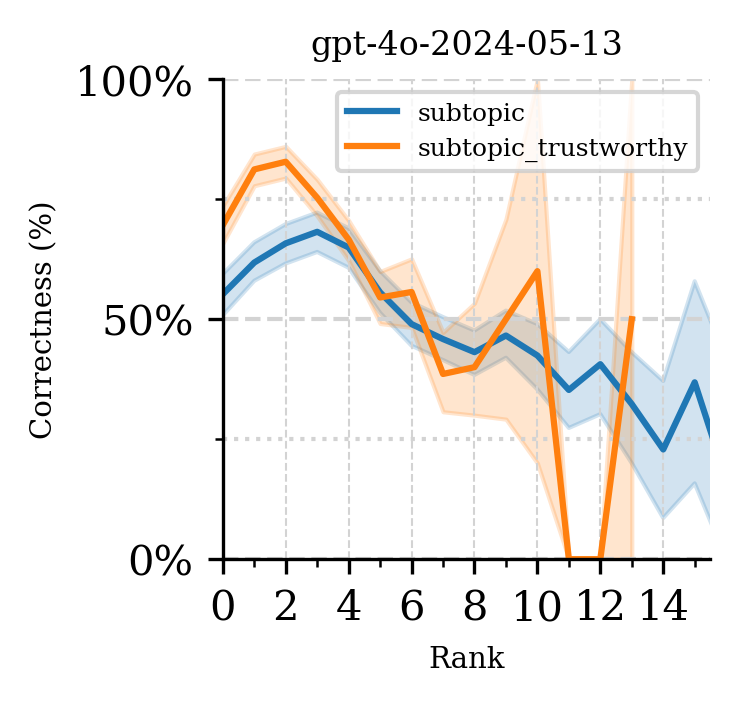

In [52]:
num_combinations = 10
model = "gpt-4o-2024-05-13"
#
subset = all_recall_results[
    (all_recall_results["num_documents"] == num_combinations)
    & (all_recall_results["label_type"] == "fc+pc")
]

subset_model = subset[subset["summarizer_model"] == model].copy()

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(COL_WIDTH/2, 2), dpi=300)

sns.lineplot(subset_model, x="rank", y="correct", hue="prompt", ax=ax)
ax.set_title(model.rpartition("/")[-1], fontsize=8)
remove_axes(ax)
ax.set_xlabel("Rank", fontsize=7)
ax.set_ylabel("Correctness (%)", fontsize=7)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(0.50))
ax.yaxis.set_major_formatter(PercentForthe abomatter(1.0))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")
ax.legend(loc="upper right", ncols=1, bbox_to_anchor=(1, 1), fontsize=6)

ax.set_ylim(0, 1)
ax.set_xlim(0, 15.5)

adjust(fig, wspace=0.1, top=0.80)
save_fig(fig, f"{domain}/{metric}/lineplot/output-position-corr/{domain}__both_prompts__{num_combinations}__{model}.png", dpi=300)

In [47]:
## Paper images:

news 2 subtopic
Image saved in ../paper-oct/images/news/bidirectional/lineplot/output-position-corr/news__subtopic__2__all_models.png
news 5 subtopic
Image saved in ../paper-oct/images/news/bidirectional/lineplot/output-position-corr/news__subtopic__5__all_models.png
news 10 subtopic
Image saved in ../paper-oct/images/news/bidirectional/lineplot/output-position-corr/news__subtopic__10__all_models.png


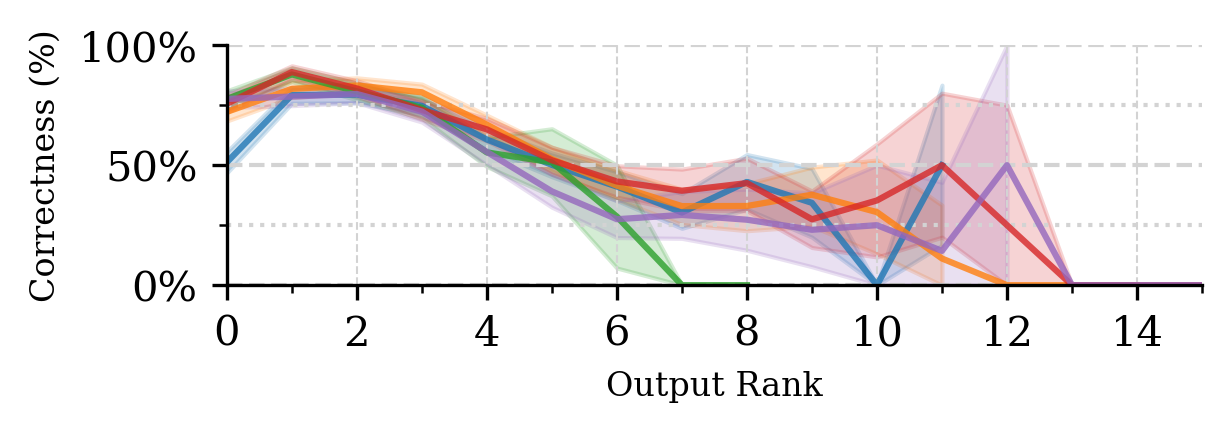

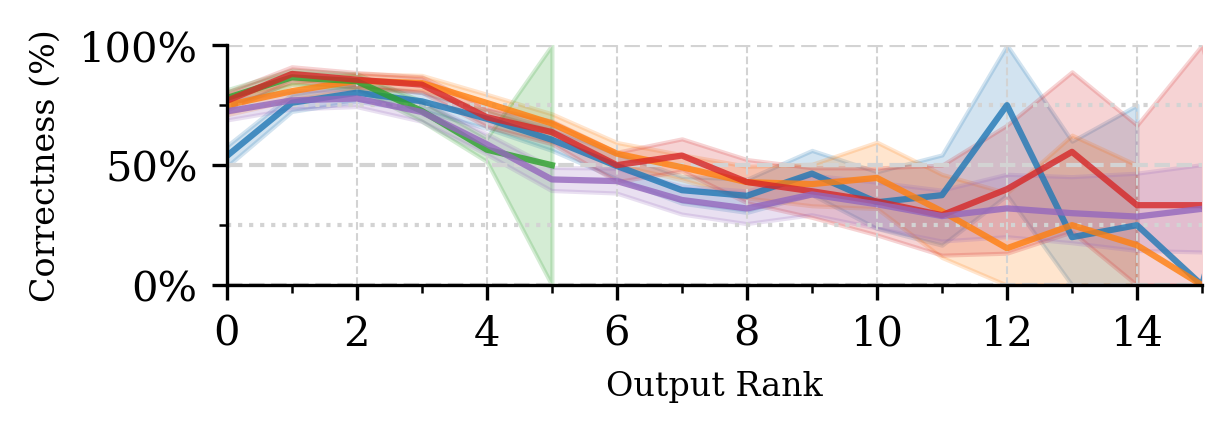

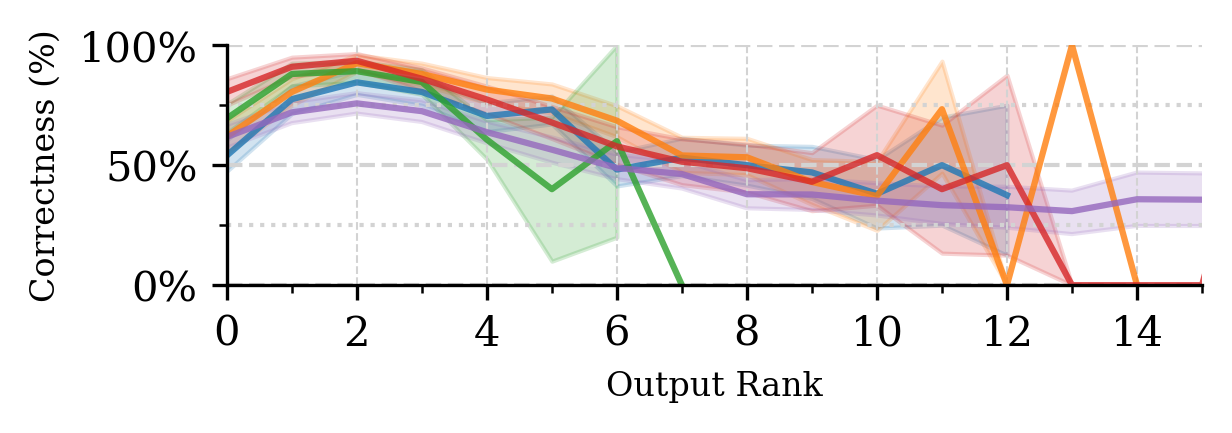

In [15]:
for num_combinations in (2, 5, 10):
    prompt_type = "subtopic"
    print(domain, num_combinations, prompt_type)
    
    subset = all_recall_results[
        (all_recall_results["num_documents"] == num_combinations)
        & (all_recall_results["label_type"] == "fc+pc")
        & (all_recall_results["prompt"] == prompt_type)
    ]
    
    fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(COL_WIDTH, 1), dpi=300)
    # fig.suptitle(f"{num_combinations} documents")
    
    i = 0
    subset_model = subset.copy()#[subset["summarizer_model"].isin(models)]
    
    sns.lineplot(subset_model, x="rank", y="correct", hue="summarizer_model", ax=ax, alpha=0.8) # change color
    remove_axes(ax)
    ax.set_ylabel("Correctness (%)", fontsize=8)
    
    # Create a DataFrame for annotation
    annotation_df = subset_model.groupby(["rank", "correct"]).size().reset_index(name='count')
    
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.50))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
    ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
    ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")
    
    if domain == "news":
        ax.get_legend().remove()
        ax.set_xlabel("Output Rank", fontsize=8)
    else:
        ax.legend(loc="upper left", ncols=5, bbox_to_anchor=(-0.2, -0.5), fontsize=4)
        ax.set_xlabel("Output Rank", fontsize=8)
    
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 15)
    
    adjust(fig, wspace=0.1, top=0.80)
    save_fig(fig, f"{domain}/{metric}/lineplot/output-position-corr/{domain}__{prompt_type}__{num_combinations}__all_models.png", dpi=300)

<Axes: xlabel='rank', ylabel='correct'>

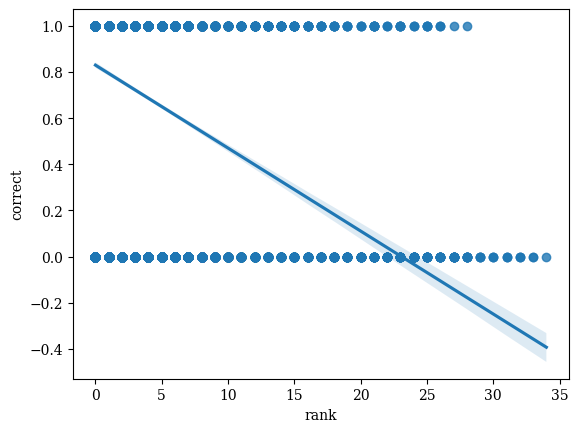

In [14]:
sns.regplot(subset_model, x="rank", y="correct")

### Paper figure 5

In [68]:
# load data: 
metric = "bidirectional"

model = "gpt-4o-2024-05-13"
max_rank = None # "num_refs" # 2
all_recall_results = []
all_err_rate_results = []

for domain in ("news", "conv"):
    for prompt in PROMPT_TYPES:
        for combination in COMBINATIONS:
            base_dir = f"../outputs_{domain}/run_final_postprocessing-multi-request/gpt-4o-mini-2024-07-18/results_some_shared"
            filepaths = sorted(glob.glob(f"{base_dir}/{prompt}/SummHay__combinations-{combination}/{model}/{metric}__*.json"))
            for filepath in filepaths: 
                data = read_json(filepath)
                recall = collect_correctness_by_position(data["labels"],
                                        ref_is_queried_subtopic=True,
                                        ref_is_shared=(prompt == "subtopic_trustworthy"),
                                        max_rank=max_rank)

                for df in (recall,):
                    df["summarizer_model"] = model.rpartition("/")[-1]
                    df["prompt"] = prompt
                    df["num_documents"] = combination
                    df["metric"] = metric
                    df["filepath"] = filepath.rpartition(metric + "__")[-1]
                    df["domain"] = domain

                all_recall_results.append(recall)

all_recall_results = pd.concat(all_recall_results)
all_recall_results.head()

response_id label_type  rank  correct  \
0            0         fc     0     True   
1            0      fc+pc     0     True   
2            0         fc     1     True   
3            0      fc+pc     1     True   
4            0         fc     2     True   

                               compute_recall_kwargs   summarizer_model  \
0  {'max_rank': None, 'ref_is_shared': False, 're...  gpt-4o-2024-05-13   
1  {'max_rank': None, 'ref_is_shared': False, 're...  gpt-4o-2024-05-13   
2  {'max_rank': None, 'ref_is_shared': False, 're...  gpt-4o-2024-05-13   
3  {'max_rank': None, 'ref_is_shared': False, 're...  gpt-4o-2024-05-13   
4  {'max_rank': None, 'ref_is_shared': False, 're...  gpt-4o-2024-05-13   

     prompt  num_documents         metric  \
0  subtopic              2  bidirectional   
1  subtopic              2  bidirectional   
2  subtopic              2  bidirectional   
3  subtopic              2  bidirectional   
4  subtopic              2  bidirectional   

                               filepath domain  
0  topic_news1__300__examples0,100.json   news  
1  topic_news1__300__examples0,100.json   news  
2  topic_news1__300__examples0,100.json   news  
3  topic_news1__300__examples0,100.json   news  
4  topic_news1__300__examples0,100.json   news

/tmp/ipykernel_135338/757640882.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")


Image saved in ../paper-oct/images/figure5__output__combination10__labelfc+pc.pdf


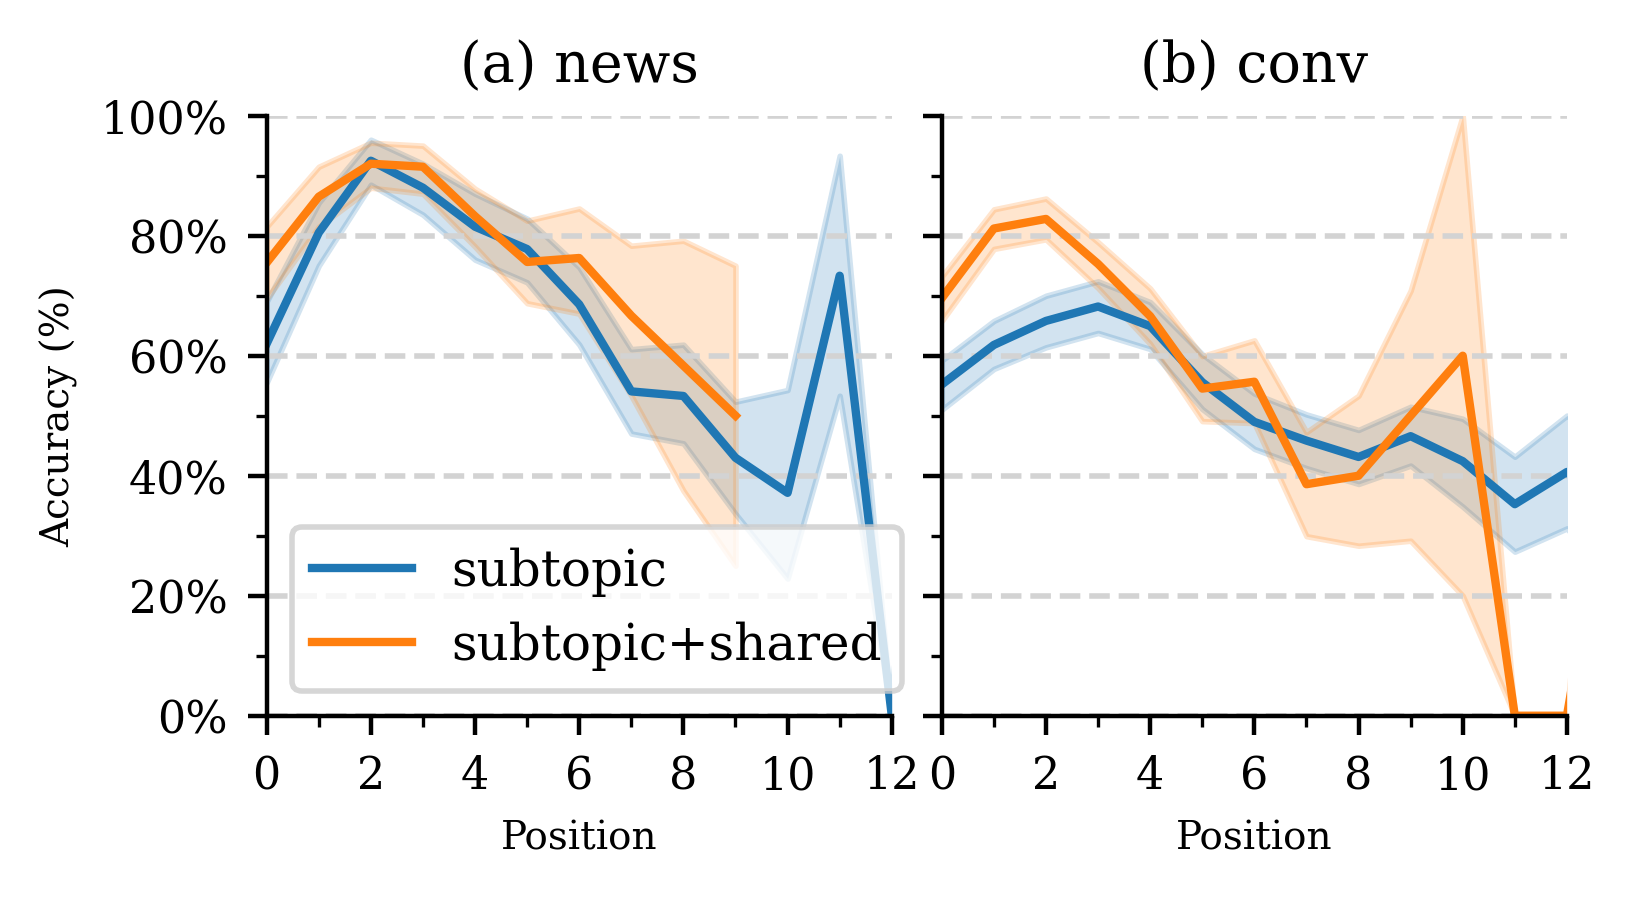

In [67]:
num_docs = 10
label_type = "fc+pc"

subset = all_recall_results[
    (all_recall_results["num_documents"] == num_docs)
    & (all_recall_results["label_type"] == label_type)
]
subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(COL_WIDTH, 1.5), dpi=400)

ax = axes[0]
subset_news = subset[subset["domain"] == "news"].copy()
sns.lineplot(subset_news, x="rank", y="correct", hue="prompt", ax=ax)
ax.set_xlabel("Position", fontsize=7)
ax.set_ylabel("Accuracy (%)", fontsize=7)
ax.set_xlim(0, 12)
remove_axes(ax)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

#ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
# ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor')
ax.set_title("(a) news", fontsize=10)
ax.legend(loc="lower left", ncols=1, bbox_to_anchor=(0, 0), fontsize=9)

ax = axes[1]
subset_conv = subset[subset["domain"] == "conv"].copy()

sns.lineplot(subset_conv, x="rank", y="correct", hue="prompt", ax=ax)
ax.set_xlabel("Position", fontsize=7)
ax.set_ylabel("Accuracy (%)", fontsize=7)
ax.set_xlim(0, 12)
ax.set_ylim(0, 1)
remove_axes(ax)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor')
ax.set_title("(b) conv", fontsize=10)
ax.get_legend().remove()

adjust(fig, wspace=0.08)
save_fig(fig, name=f"figure5__output__combination{num_docs}__label{label_type}__{model}.pdf", dpi=400)

## Appendix (N=10, N=2)

/tmp/ipykernel_135338/1692325316.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")


Image saved in ../paper-oct/images/figure5__output__combination2__labelfc+pc__llama-v3p1-70b-instruct.pdf


/tmp/ipykernel_135338/1692325316.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")


Image saved in ../paper-oct/images/figure5__output__combination10__labelfc+pc__llama-v3p1-70b-instruct.pdf


/tmp/ipykernel_135338/1692325316.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")


Image saved in ../paper-oct/images/figure5__output__combination2__labelfc+pc__gpt-4o-2024-05-13.pdf


/tmp/ipykernel_135338/1692325316.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")


Image saved in ../paper-oct/images/figure5__output__combination10__labelfc+pc__gpt-4o-2024-05-13.pdf


/tmp/ipykernel_135338/1692325316.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")


Image saved in ../paper-oct/images/figure5__output__combination2__labelfc+pc__gpt-3.5-turbo-0125.pdf


/tmp/ipykernel_135338/1692325316.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")


Image saved in ../paper-oct/images/figure5__output__combination10__labelfc+pc__gpt-3.5-turbo-0125.pdf


/tmp/ipykernel_135338/1692325316.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")


Image saved in ../paper-oct/images/figure5__output__combination2__labelfc+pc__qwen2-72b-instruct.pdf


/tmp/ipykernel_135338/1692325316.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")


Image saved in ../paper-oct/images/figure5__output__combination10__labelfc+pc__qwen2-72b-instruct.pdf


/tmp/ipykernel_135338/1692325316.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")


Image saved in ../paper-oct/images/figure5__output__combination2__labelfc+pc__gemini-1.5-flash.pdf


/tmp/ipykernel_135338/1692325316.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")


Image saved in ../paper-oct/images/figure5__output__combination10__labelfc+pc__gemini-1.5-flash.pdf


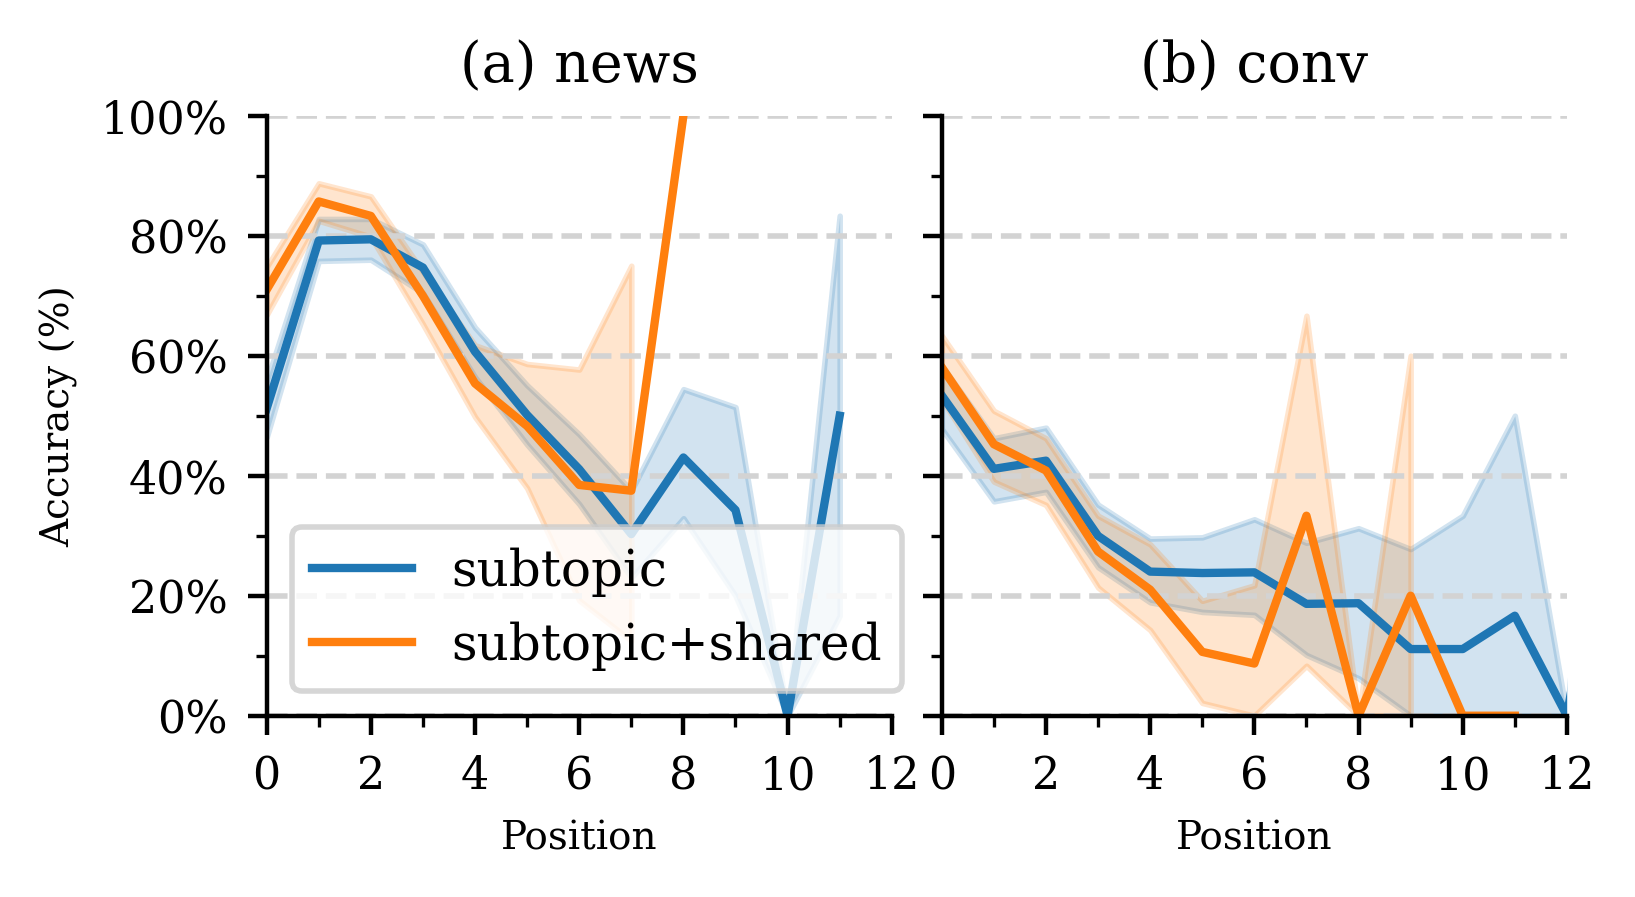

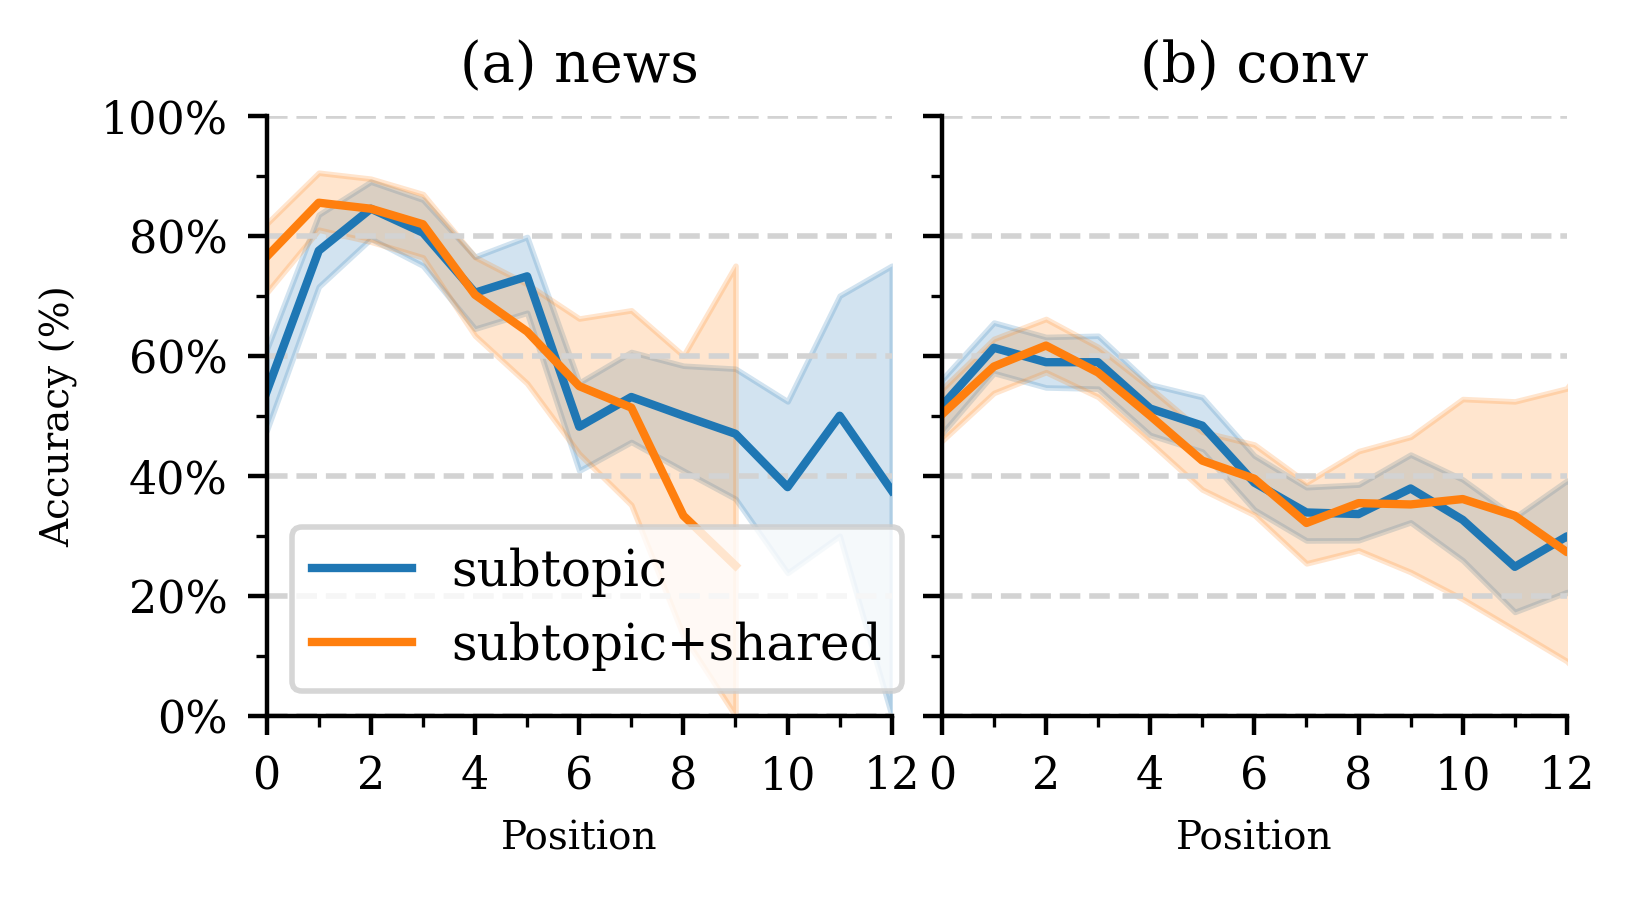

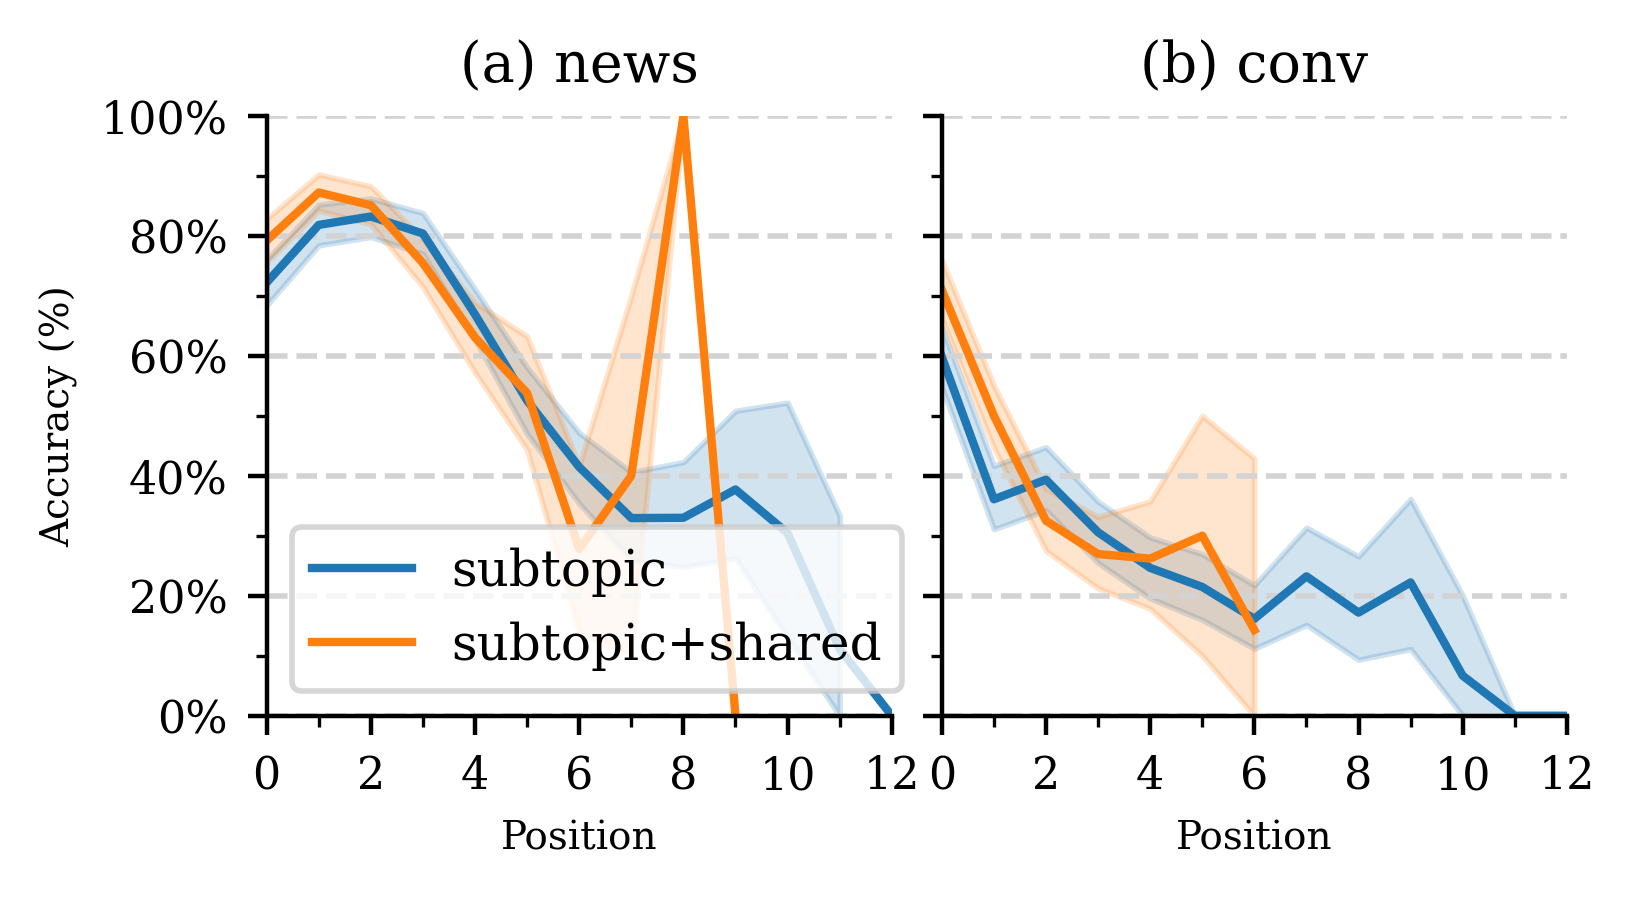

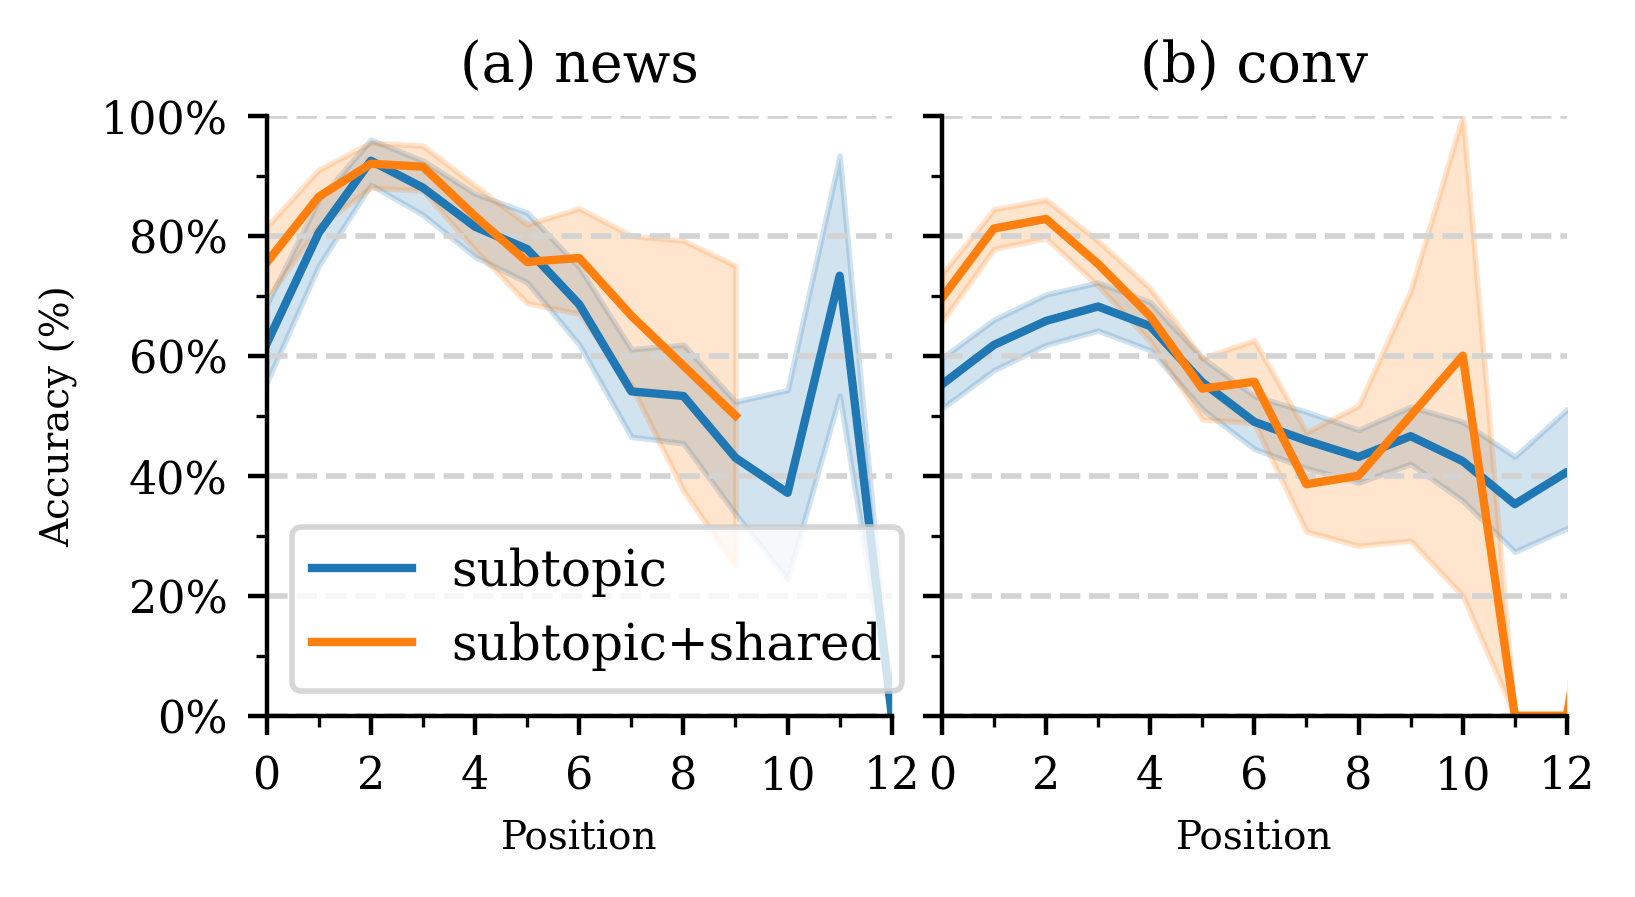

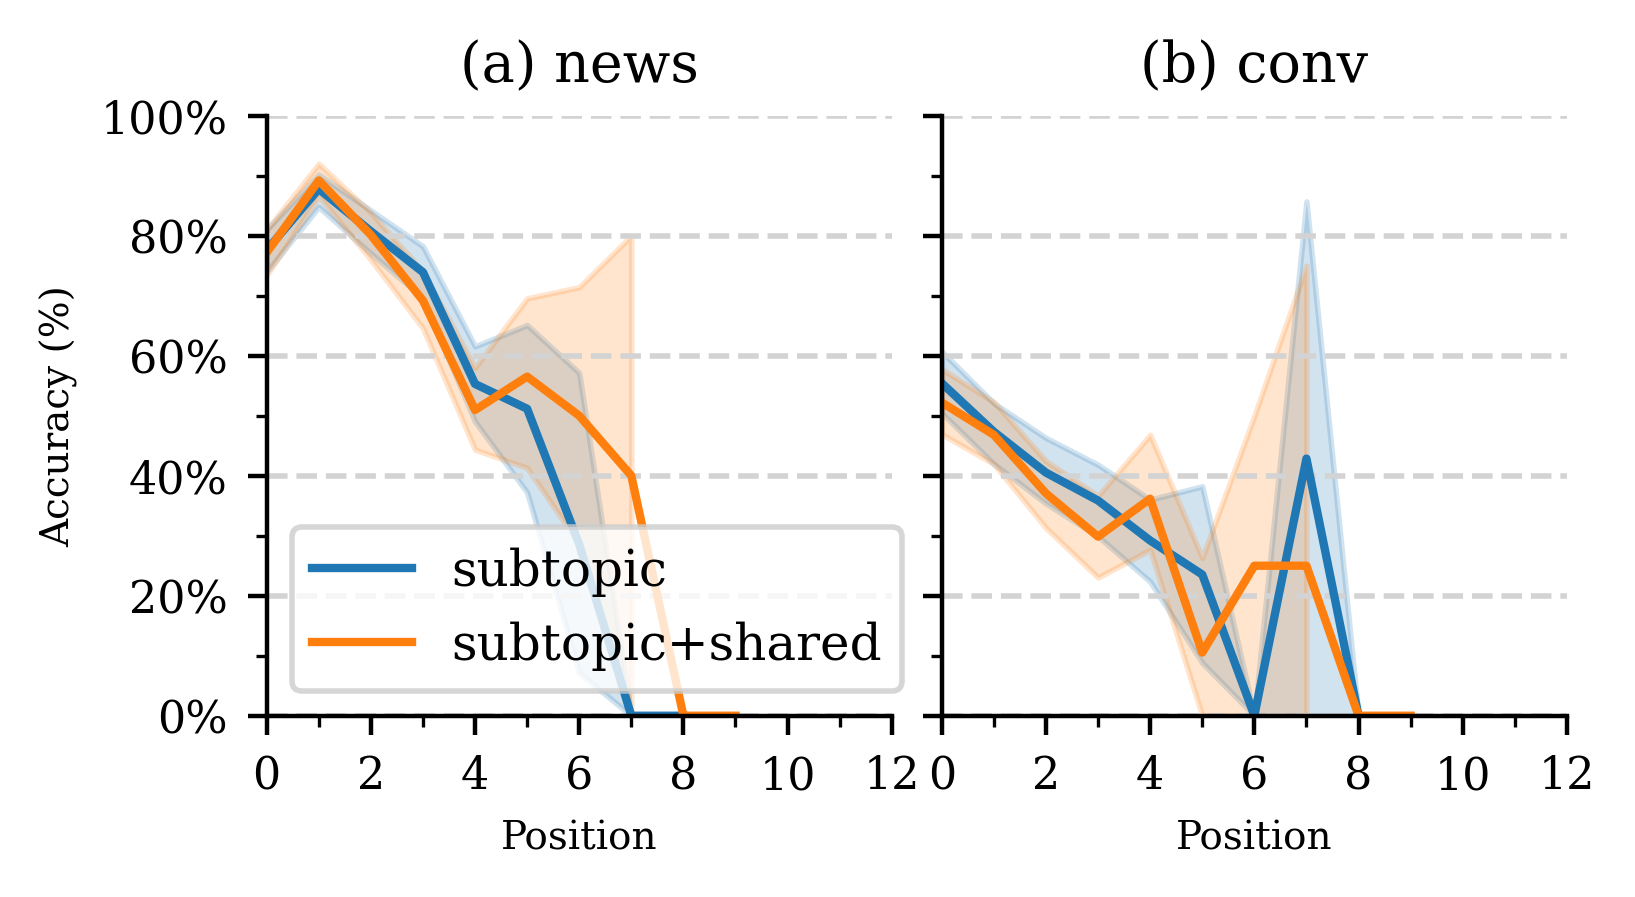

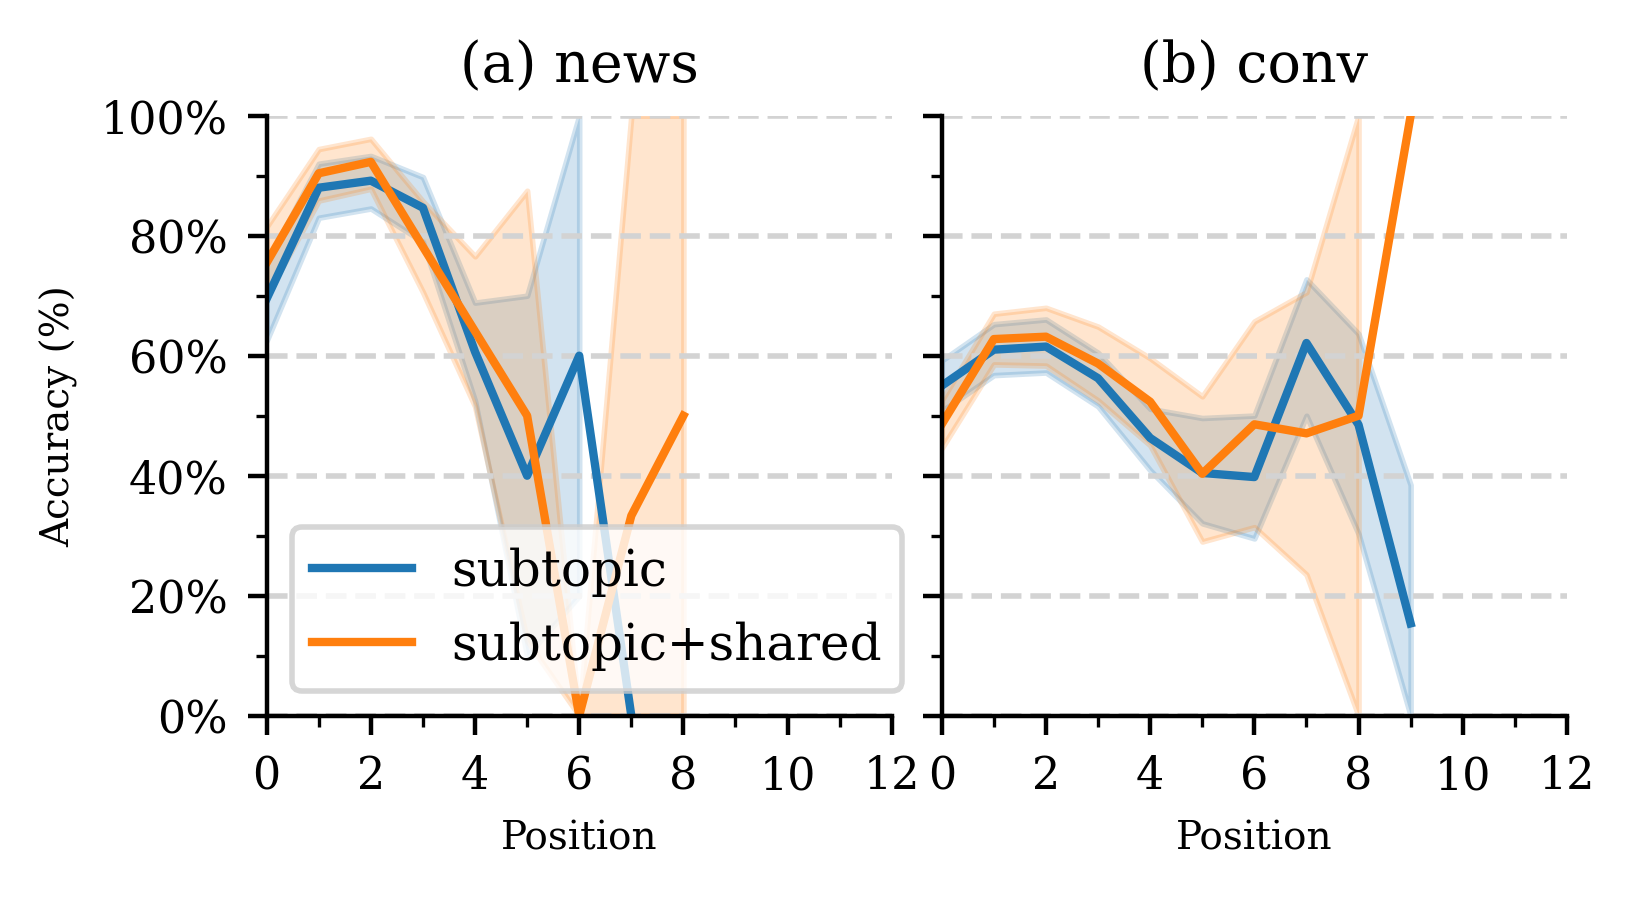

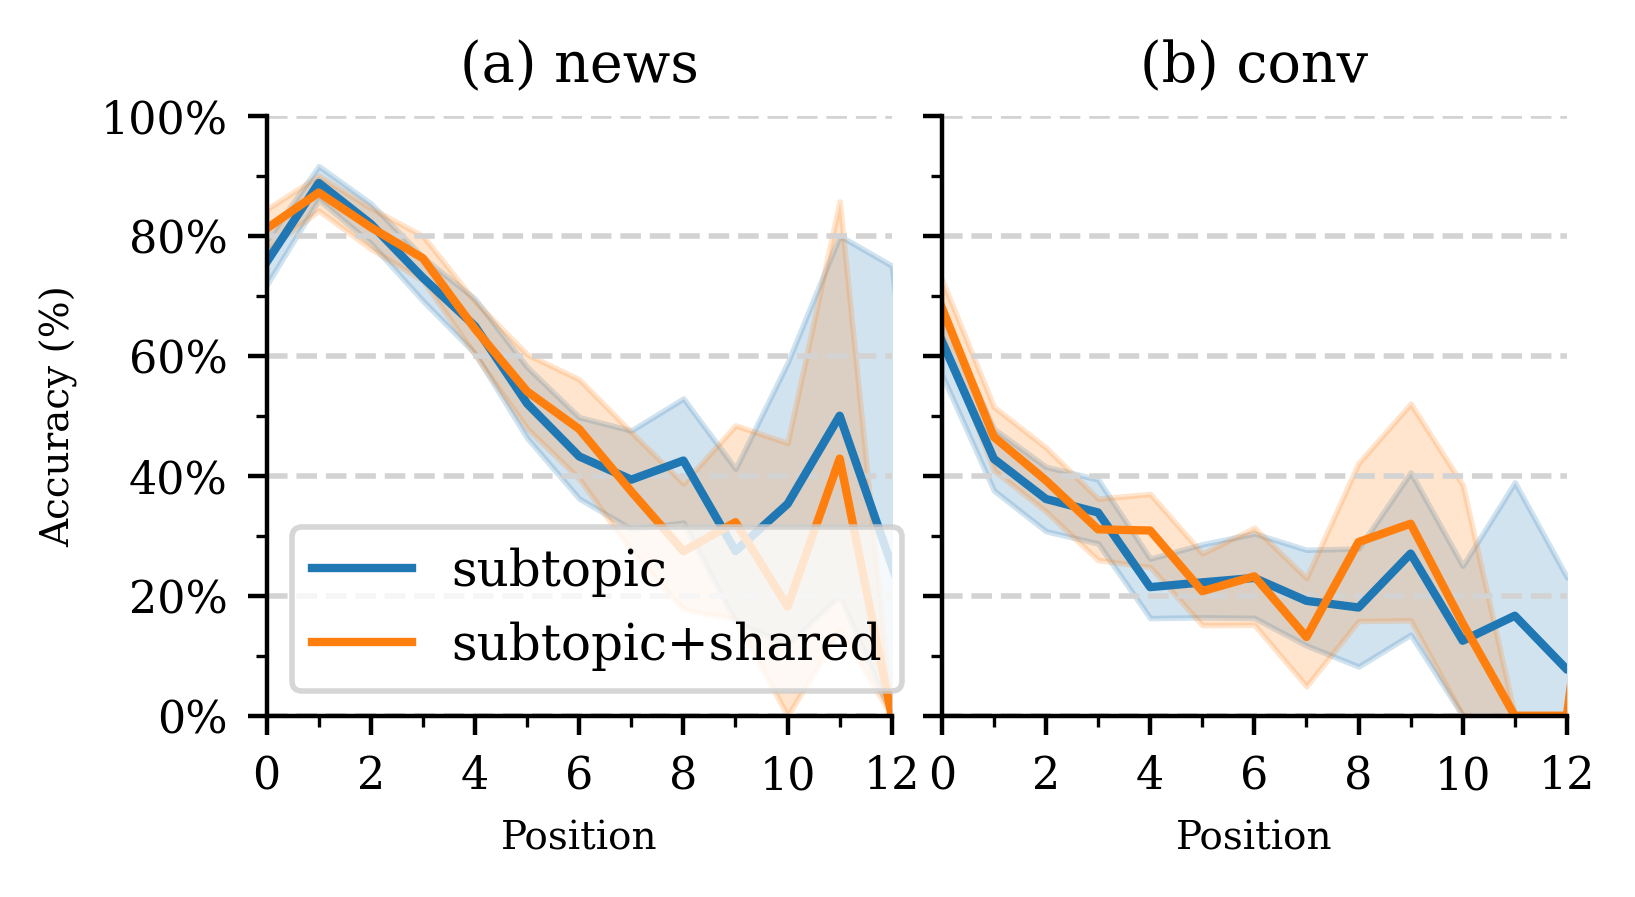

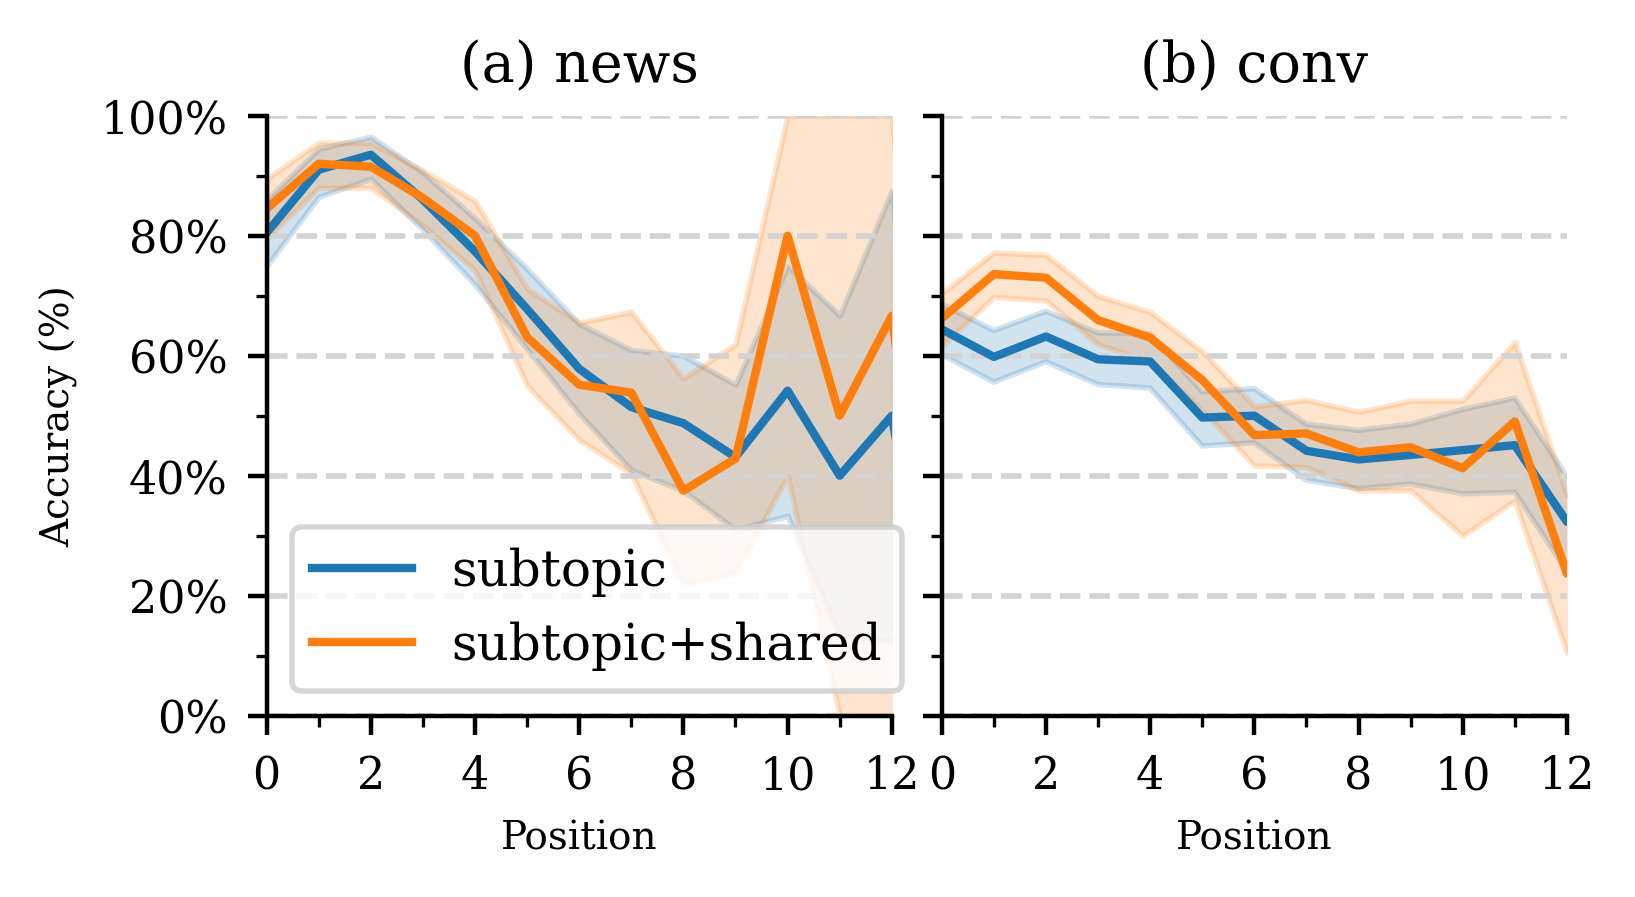

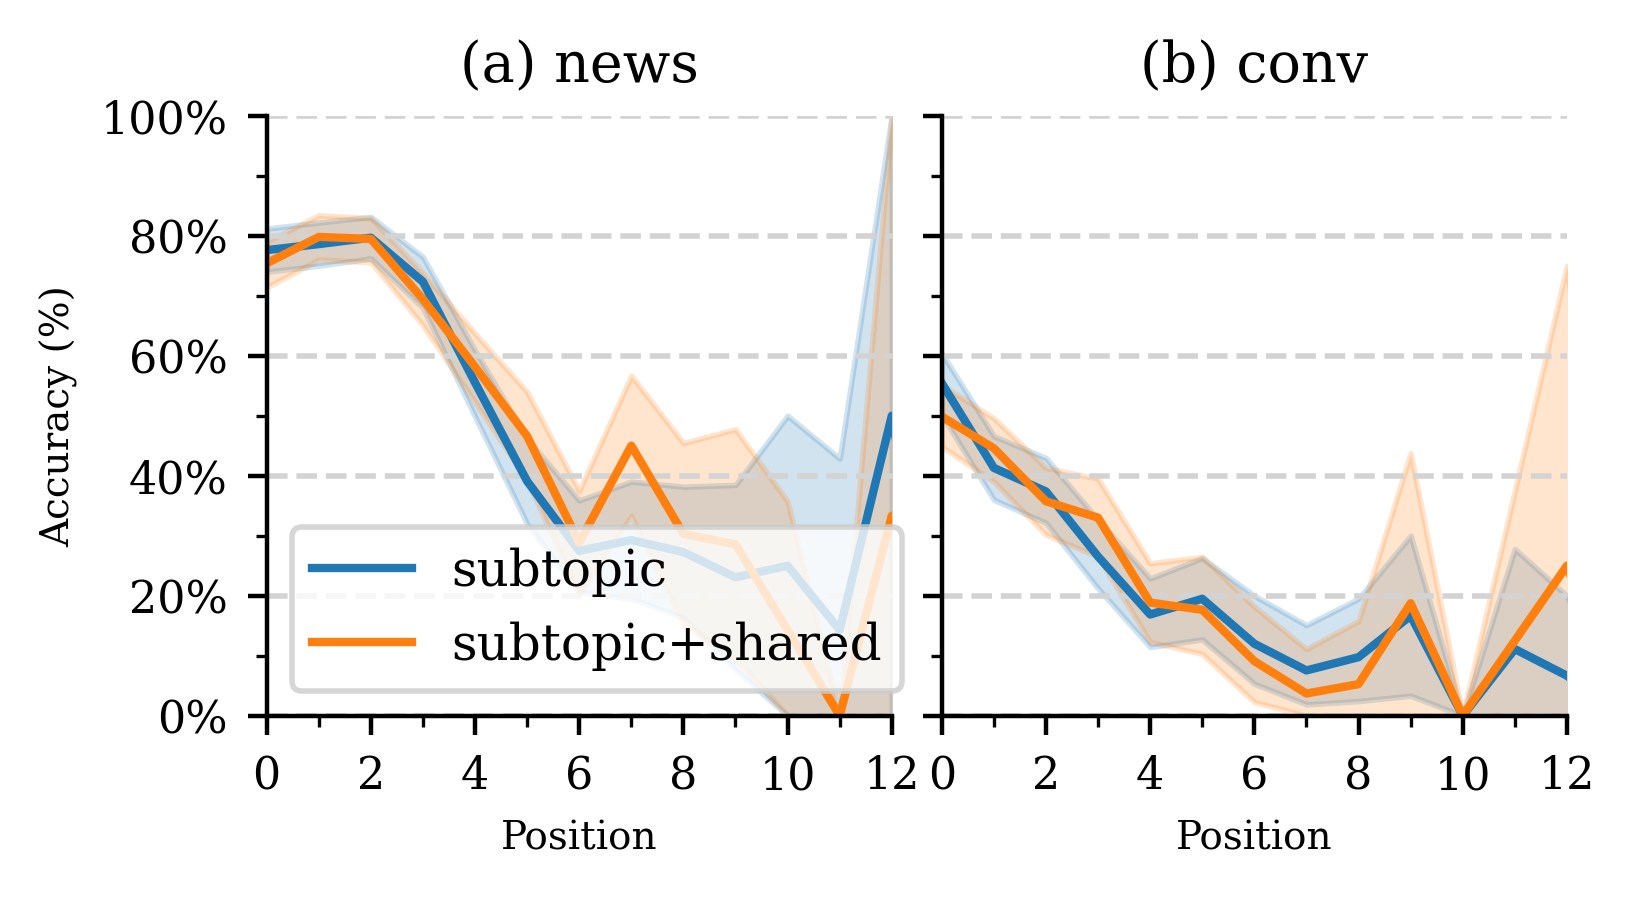

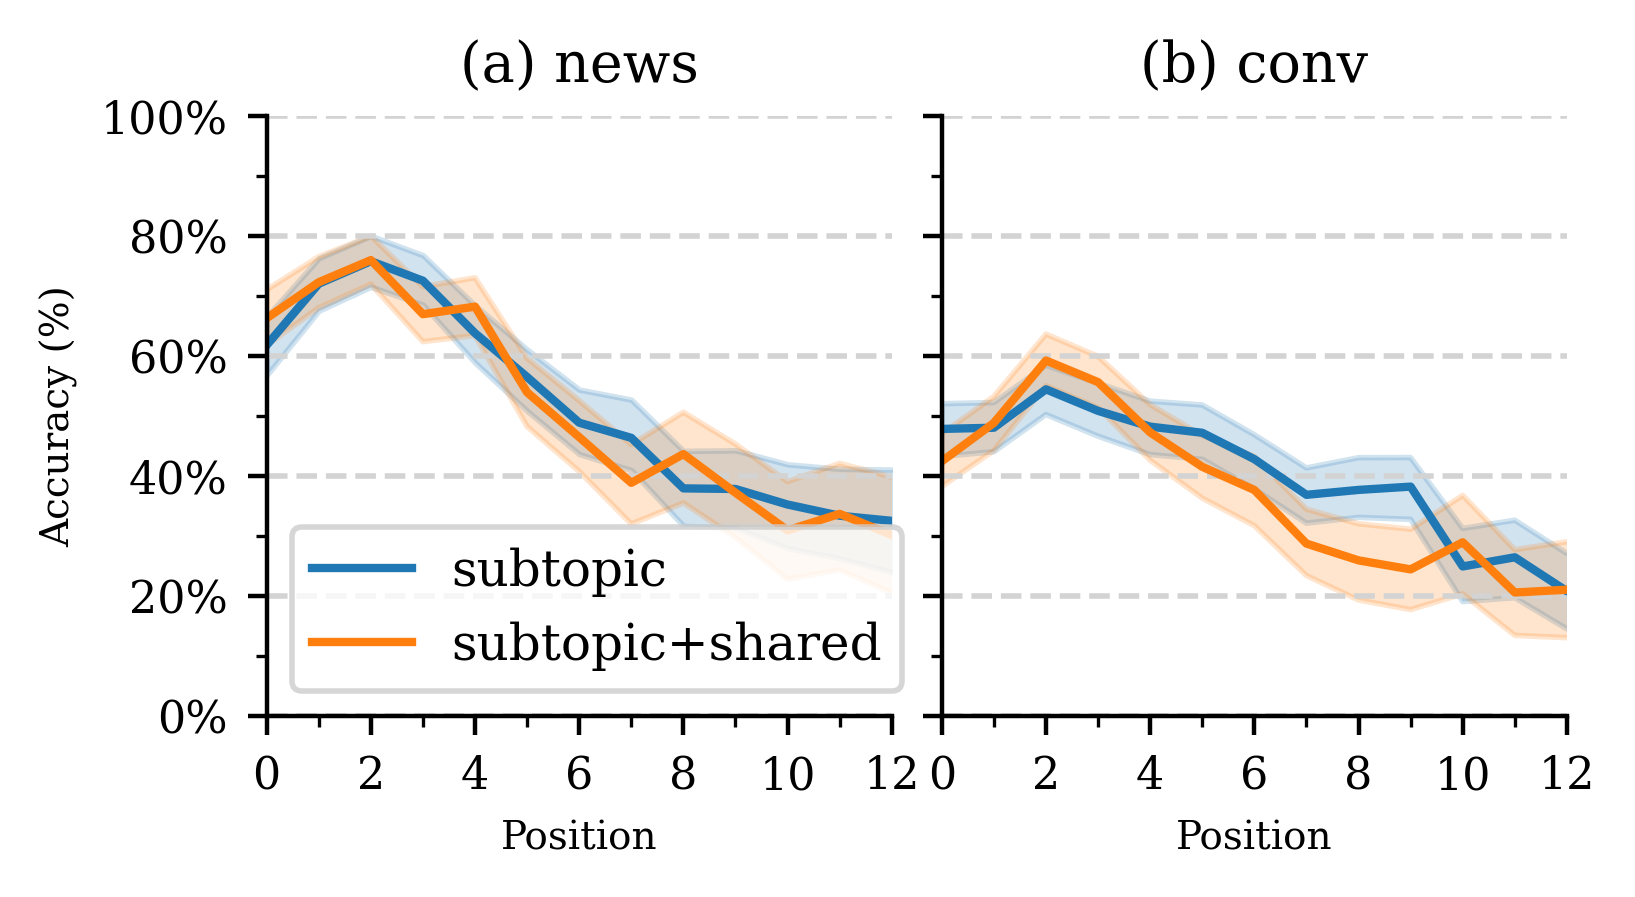

In [71]:
# load data: 
metric = "bidirectional"
domain = "conv"

max_rank = None # "num_refs" # 2

for model in MODELS:
    for combination in (2, 10):
        all_recall_results = []
        for domain in ("news", "conv"):
            for prompt in PROMPT_TYPES:
                base_dir = f"../outputs_{domain}/run_final_postprocessing-multi-request/gpt-4o-mini-2024-07-18/results_some_shared"
                filepaths = sorted(glob.glob(f"{base_dir}/{prompt}/SummHay__combinations-{combination}/{model}/{metric}__*.json"))
                for filepath in filepaths: 
                    data = read_json(filepath)
                    recall = collect_correctness_by_position(data["labels"],
                                            ref_is_queried_subtopic=True,
                                            ref_is_shared=(prompt == "subtopic_trustworthy"),
                                            max_rank=max_rank)
    
                    for df in (recall,):
                        df["summarizer_model"] = model.rpartition("/")[-1]
                        df["prompt"] = prompt
                        df["num_documents"] = combination
                        df["metric"] = metric
                        df["filepath"] = filepath.rpartition(metric + "__")[-1]
                        df["domain"] = domain
    
                    all_recall_results.append(recall)

        all_recall_results = pd.concat(all_recall_results)
        num_docs = combination
        label_type = "fc+pc"
        
        subset = all_recall_results[
            (all_recall_results["num_documents"] == num_docs)
            & (all_recall_results["label_type"] == label_type)
        ]
        subset["prompt"] = subset["prompt"].apply(lambda x: x if x == "subtopic" else "subtopic+shared")
        fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(COL_WIDTH, 1.5), dpi=400)
        
        ax = axes[0]
        subset_news = subset[subset["domain"] == "news"].copy()
        sns.lineplot(subset_news, x="rank", y="correct", hue="prompt", ax=ax)
        ax.set_xlabel("Position", fontsize=7)
        ax.set_ylabel("Accuracy (%)", fontsize=7)
        ax.set_xlim(0, 12)
        remove_axes(ax)
        
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.xaxis.set_major_locator(MultipleLocator(2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(0.20))
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        
        #ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
        ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
        # ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor')
        ax.set_title("(a) news", fontsize=10)
        ax.legend(loc="lower left", ncols=1, bbox_to_anchor=(0, 0), fontsize=9)
        
        ax = axes[1]
        subset_conv = subset[subset["domain"] == "conv"].copy()
        
        sns.lineplot(subset_conv, x="rank", y="correct", hue="prompt", ax=ax)
        ax.set_xlabel("Position", fontsize=7)
        ax.set_ylabel("Accuracy (%)", fontsize=7)
        ax.set_xlim(0, 12)
        ax.set_ylim(0, 1)
        remove_axes(ax)
        
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.xaxis.set_major_locator(MultipleLocator(2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))
        ax.yaxis.set_major_locator(MultipleLocator(0.20))
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor')
        ax.set_title("(b) conv", fontsize=10)
        ax.get_legend().remove()
        
        adjust(fig, wspace=0.08)
        model_name = model.rpartition("/")[-1]
        save_fig(fig, name=f"figure5__output__combination{num_docs}__label{label_type}__{model_name}.pdf", dpi=400)